In [1]:
import sys
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../..")))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from scipy import stats
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from bcd.explore.meta.case import CaseExplorer
from bcd.explore.meta.multivariate.pipeline import PipelineBuilder
from bcd.explore.meta.multivariate.selection import ModelSelector

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
sns.set_style('whitegrid')
sns.set_palette("Blues_r")

In [3]:
CASE_FP = "data/meta/3_cooked/cases.csv"

In [4]:
cases = CaseExplorer(filepath=CASE_FP)
calc = CaseExplorer(df=cases.get_calc_data())
mass = CaseExplorer(df=cases.get_mass_data())

In [5]:
summary = cases.summary()
summary

,Summary
Patients,1566
Cases,3566
Calcification Cases,1872
Calcification Cases - Benign,1199
Calcification Cases - Malignant,673
Mass Cases,1694
Mass Cases - Benign,910
Mass Cases - Malignant,784


In [6]:
st = summary.T
pct_calc = round(st['Calcification Cases'] / st['Cases'] * 100,2).values[0]
pct_mass = round(st['Mass Cases'] / st['Cases'] * 100,2).values[0]
pct_calc_mal = round(st['Calcification Cases - Malignant'] / st['Calcification Cases'] * 100,2).values[0]
pct_calc_bn = round(st['Calcification Cases - Benign'] / st['Calcification Cases'] * 100,2).values[0]
pct_mass_mal = round(st['Mass Cases - Malignant'] / st['Mass Cases'] * 100,2).values[0]
pct_mass_bn = round(st['Mass Cases - Benign'] / st['Mass Cases'] * 100,2).values[0]
cases_per_patient = round(st['Cases'] / st['Patients'],2).values[0]
msg = f"Key Observations\n"
msg += f"1.\tThe number of patients, {st['Patients'].values[0]} comports with the TCIA data description.\n"
msg += f"2.\tWe have {st['Cases'].values[0]} cases, {pct_calc}% are calcification cases and {pct_mass}% are mass cases.\n"
msg += f"3.\tOf the calcification cases, {pct_calc_bn}% are benign, {pct_calc_mal} or malignant.\n"
msg += f"4.\tOf the mass cases, {pct_mass_bn}% are benign, {pct_mass_mal} or malignant.\n"
msg += f"5\tOn average we have approximately {cases_per_patient} cases per patient."
print(msg)

Key Observations
1.	The number of patients, 1566 comports with the TCIA data description.
2.	We have 3566 cases, 52.5% are calcification cases and 47.5% are mass cases.
3.	Of the calcification cases, 64.05% are benign, 35.95 or malignant.
4.	Of the mass cases, 53.72% are benign, 46.28 or malignant.
5	On average we have approximately 2.28 cases per patient.


In [7]:
cases.get_calc_data().sample(5)
cases.get_mass_data().sample(5)

,case_id,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,calc_type,calc_distribution,assessment,pathology,subtlety,fileset,cancer
928,Calcification-Train_P_01186_LEFT_CC_1,P_01186,2,LEFT,CC,1,FINE_LINEAR_BRANCHING,LINEAR,4,BENIGN,5,train,False
1766,Calcification-Test_P_01419_LEFT_CC_1,P_01419,3,LEFT,CC,1,FINE_LINEAR_BRANCHING,LINEAR,5,MALIGNANT,4,test,True
1501,Calcification-Train_P_02400_LEFT_CC_1,P_02400,1,LEFT,CC,1,FINE_LINEAR_BRANCHING,CLUSTERED,3,MALIGNANT,2,train,True
1300,Calcification-Train_P_01691_RIGHT_MLO_2,P_01691,3,RIGHT,MLO,2,ROUND_AND_REGULAR-LUCENT_CENTERED,SEGMENTAL,2,BENIGN_WITHOUT_CALLBACK,3,train,False
834,Calcification-Train_P_01066_RIGHT_CC_1,P_01066,3,RIGHT,CC,1,PLEOMORPHIC,CLUSTERED,4,BENIGN,2,train,False


,case_id,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,mass_shape,mass_margins,assessment,pathology,subtlety,fileset,cancer
2101,Mass-Train_P_00333_RIGHT_CC_1,P_00333,2,RIGHT,CC,1,OVAL,OBSCURED,0,BENIGN,3,train,False
3533,Mass-Test_P_01697_LEFT_CC_1,P_01697,2,LEFT,CC,1,ROUND,MICROLOBULATED,4,BENIGN,3,test,False
3537,Mass-Test_P_01719_RIGHT_CC_1,P_01719,3,RIGHT,CC,1,OVAL,ILL_DEFINED,4,MALIGNANT,2,test,True
2987,Mass-Train_P_01621_RIGHT_CC_1,P_01621,1,RIGHT,CC,1,LOBULATED,OBSCURED,3,BENIGN,5,train,False
3430,Mass-Test_P_01183_LEFT_CC_1,P_01183,2,LEFT,CC,1,ROUND,MICROLOBULATED,4,BENIGN,3,test,False


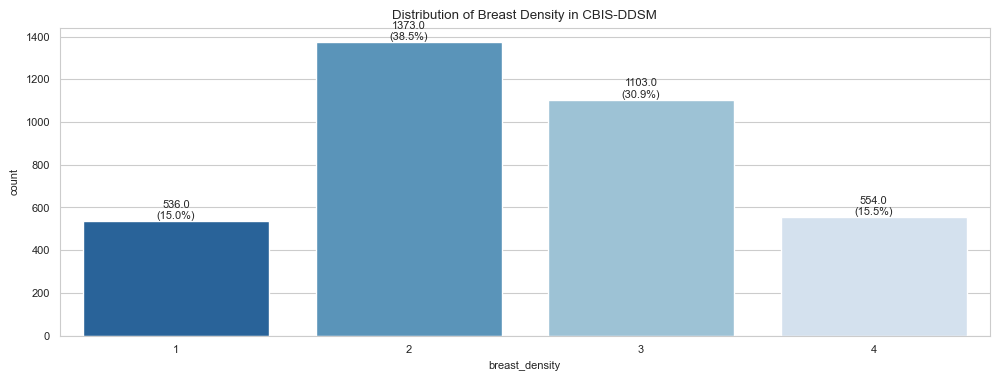

In [8]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='breast_density', ax=ax, title ="Distribution of Breast Density in CBIS-DDSM", plot_counts=True)

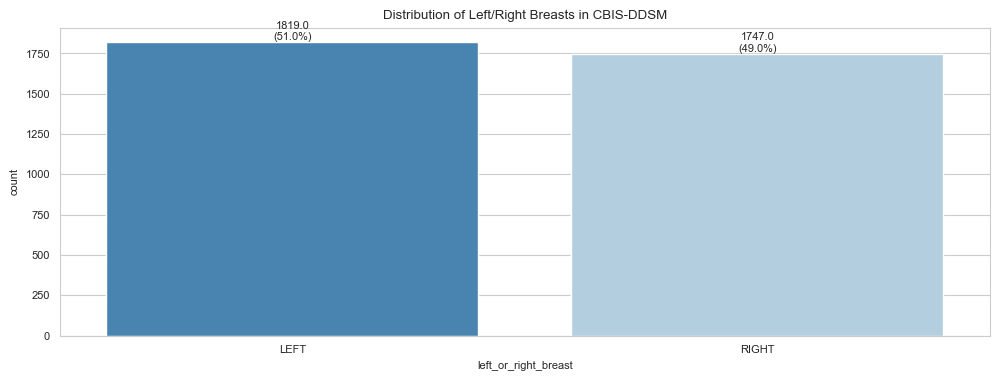

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='left_or_right_breast', ax=ax, title ="Distribution of Left/Right Breasts in CBIS-DDSM", plot_counts=True)

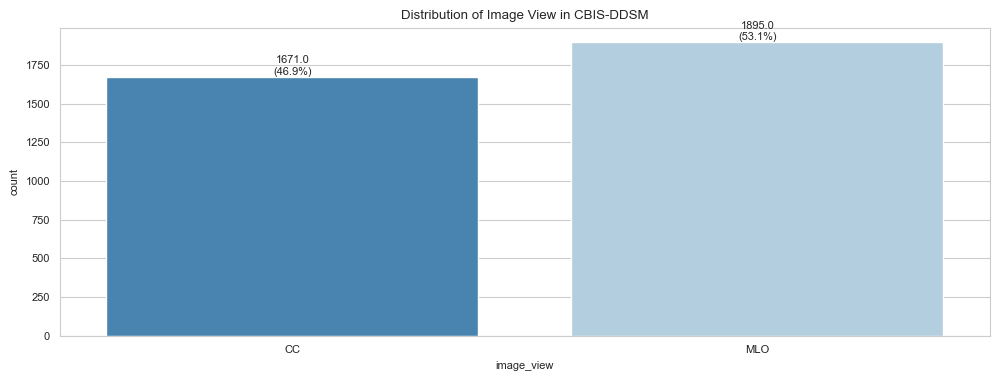

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='image_view', ax=ax, title ="Distribution of Image View in CBIS-DDSM", plot_counts=True)

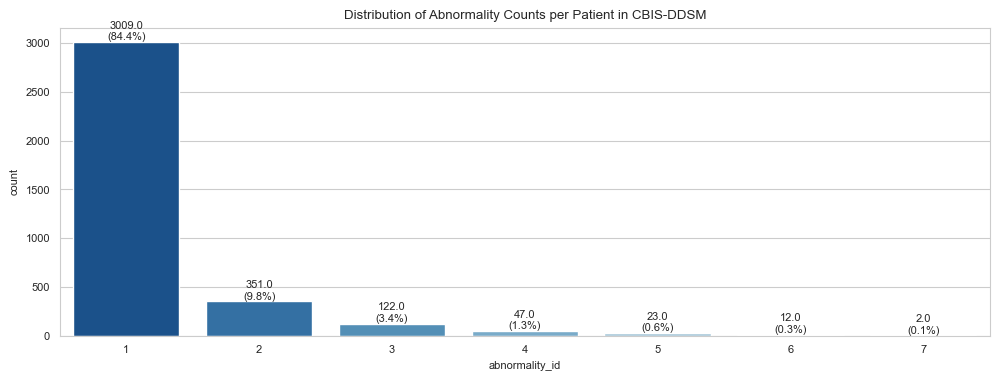

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='abnormality_id', ax=ax, title ="Distribution of Abnormality Counts per Patient in CBIS-DDSM", plot_counts=True)

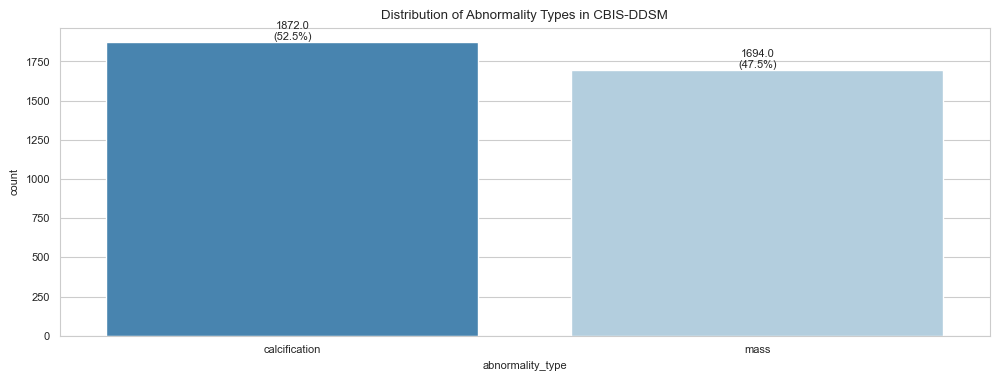

In [12]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='abnormality_type', ax=ax, title ="Distribution of Abnormality Types in CBIS-DDSM", plot_counts=True)

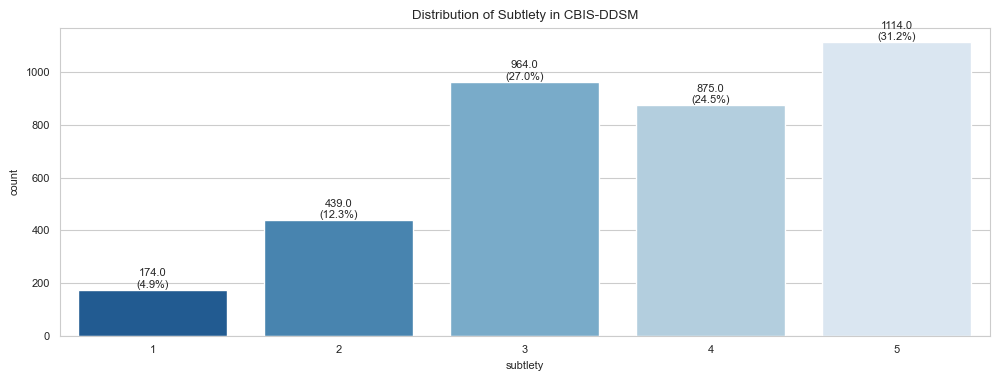

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='subtlety', ax=ax, title ="Distribution of Subtlety in CBIS-DDSM", plot_counts=True)

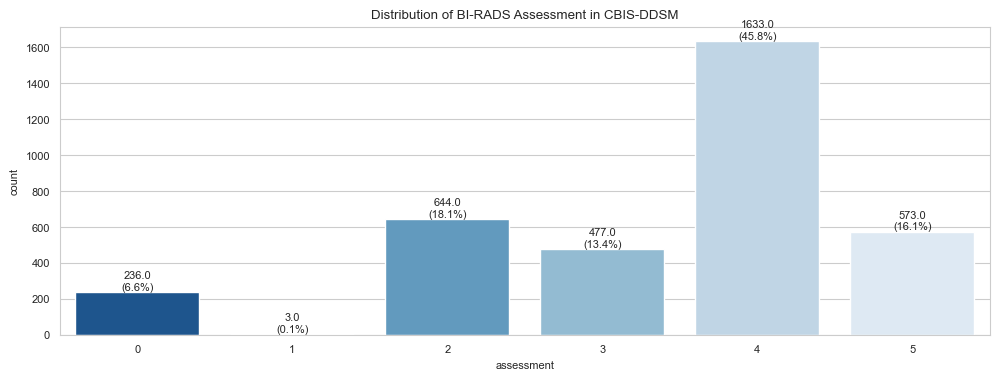

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='assessment', ax=ax, title ="Distribution of BI-RADS Assessment in CBIS-DDSM", plot_counts=True)

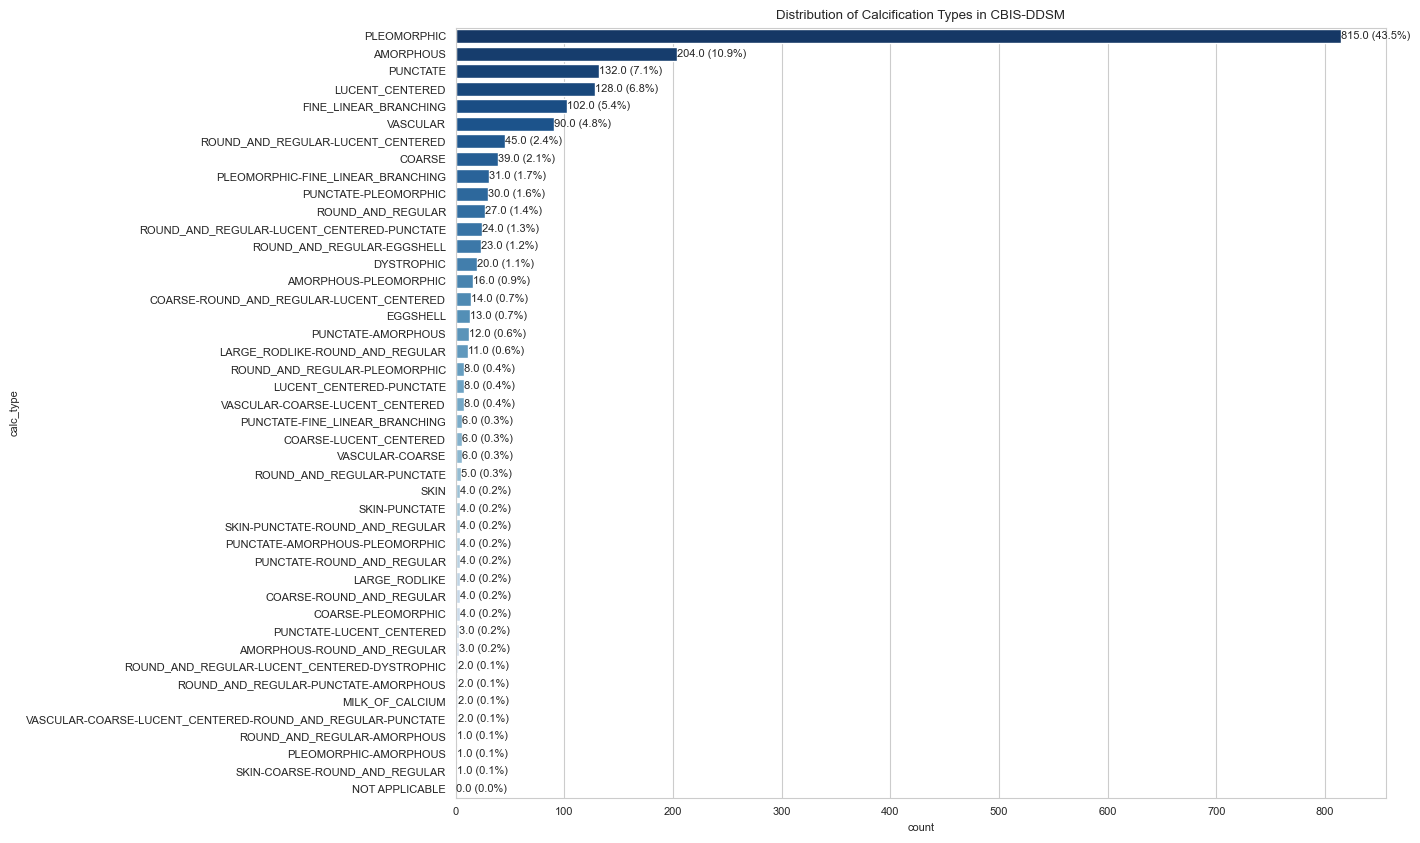

In [15]:
fig, ax = plt.subplots(figsize=(12,10))
calc.plot.countplot(y='calc_type', ax=ax, title ="Distribution of Calcification Types in CBIS-DDSM", plot_counts=True, order_by_count=True)

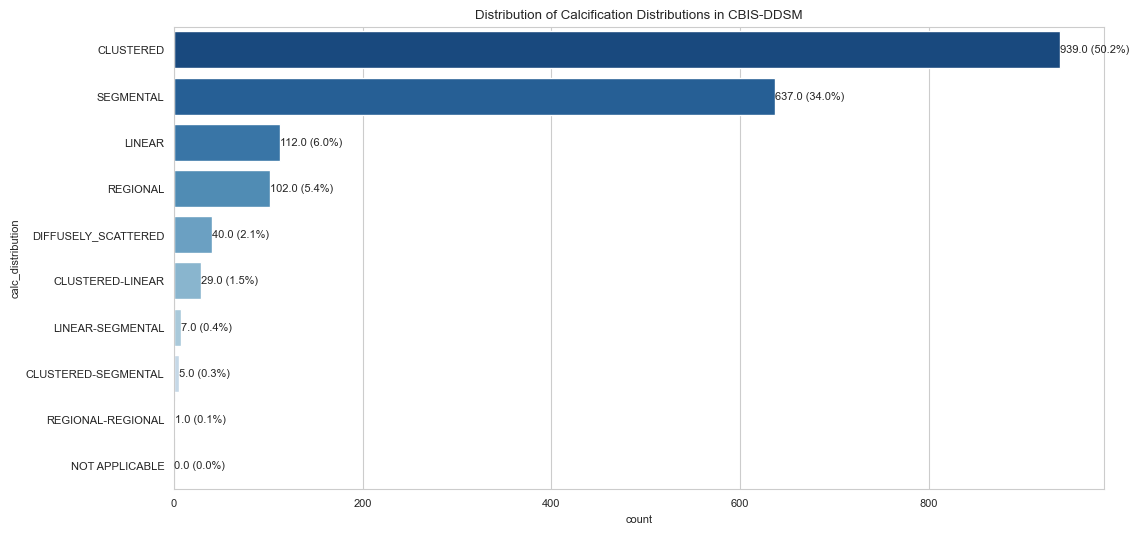

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
calc.plot.countplot(y='calc_distribution', ax=ax, title ="Distribution of Calcification Distributions in CBIS-DDSM", plot_counts=True, order_by_count=True)

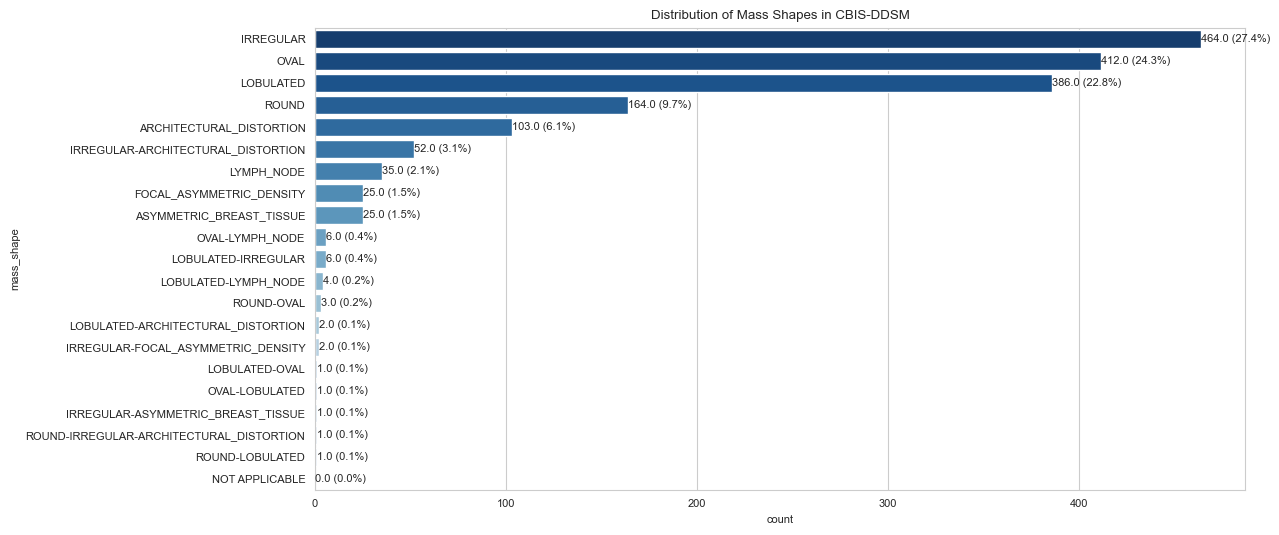

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
mass.plot.countplot(y='mass_shape', ax=ax, title ="Distribution of Mass Shapes in CBIS-DDSM", plot_counts=True, order_by_count=True)

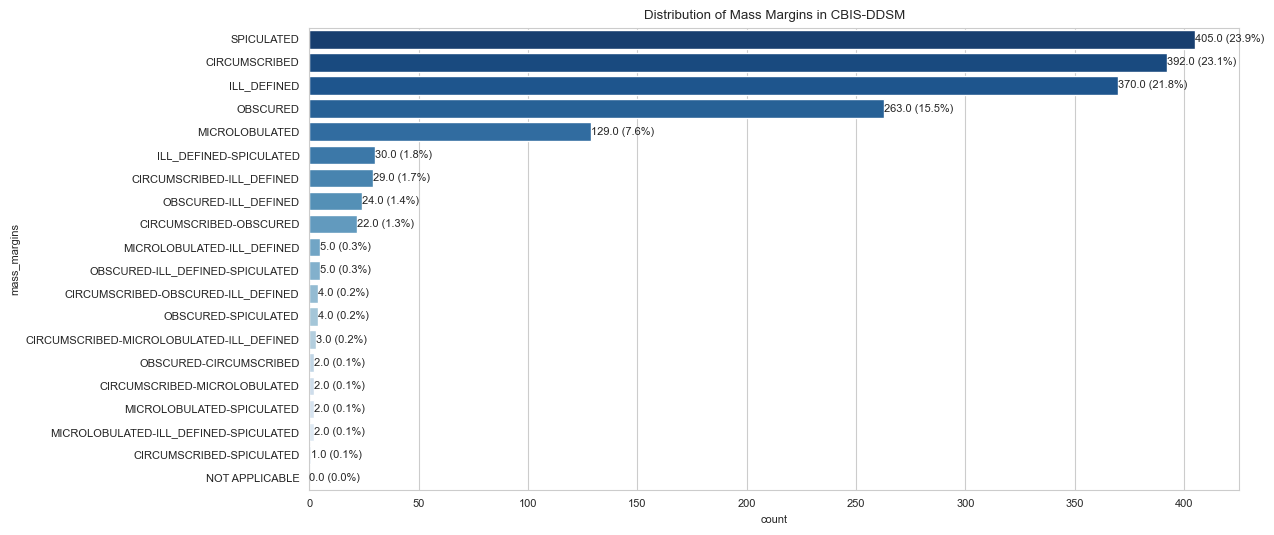

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
mass.plot.countplot(y='mass_margins', ax=ax, title ="Distribution of Mass Margins in CBIS-DDSM", plot_counts=True, order_by_count=True)

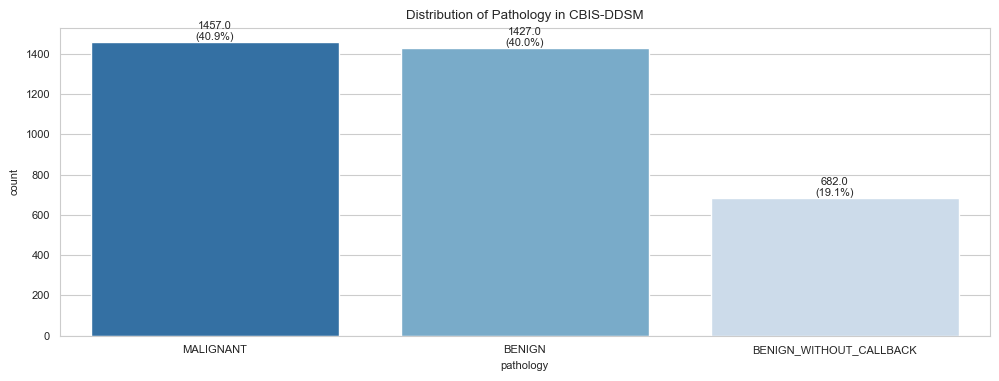

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='pathology', ax=ax, title ="Distribution of Pathology in CBIS-DDSM", plot_counts=True, order_by_count=True)

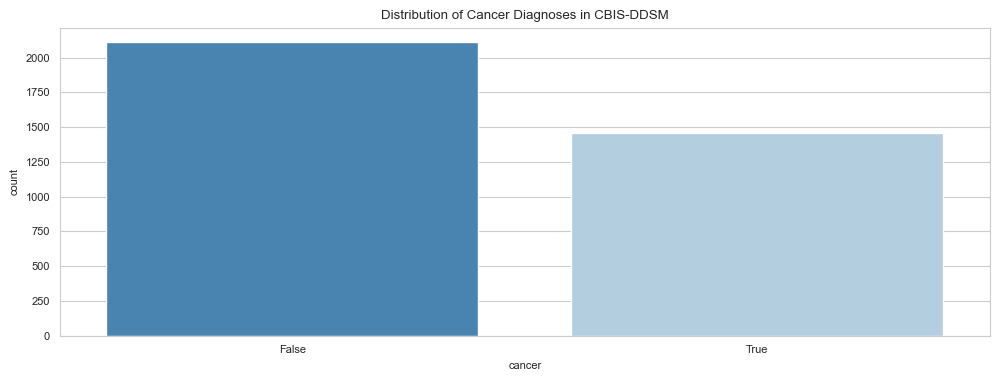

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='cancer', ax=ax, title ="Distribution of Cancer Diagnoses in CBIS-DDSM")

In [21]:
df = cases.as_df(categorize_ordinals=True)

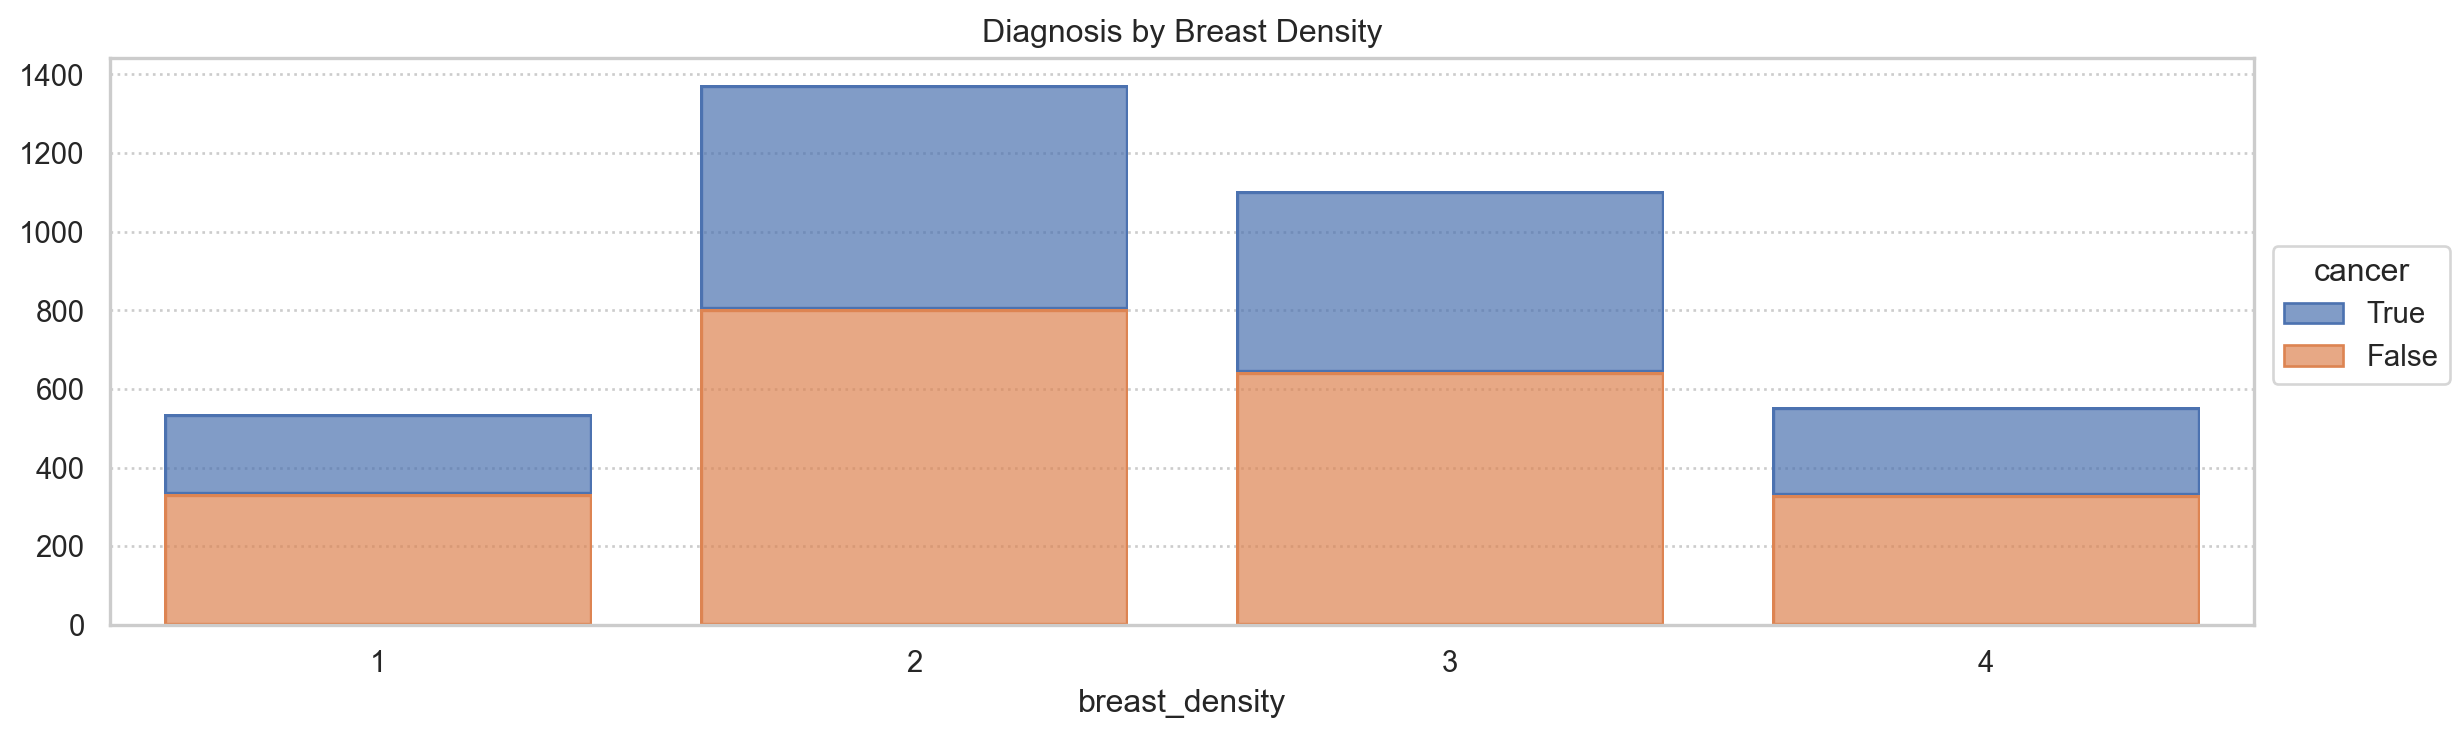

In [22]:
sns.objects.Plot(df, x='breast_density', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Breast Density").layout(size=(12,4), engine='tight')

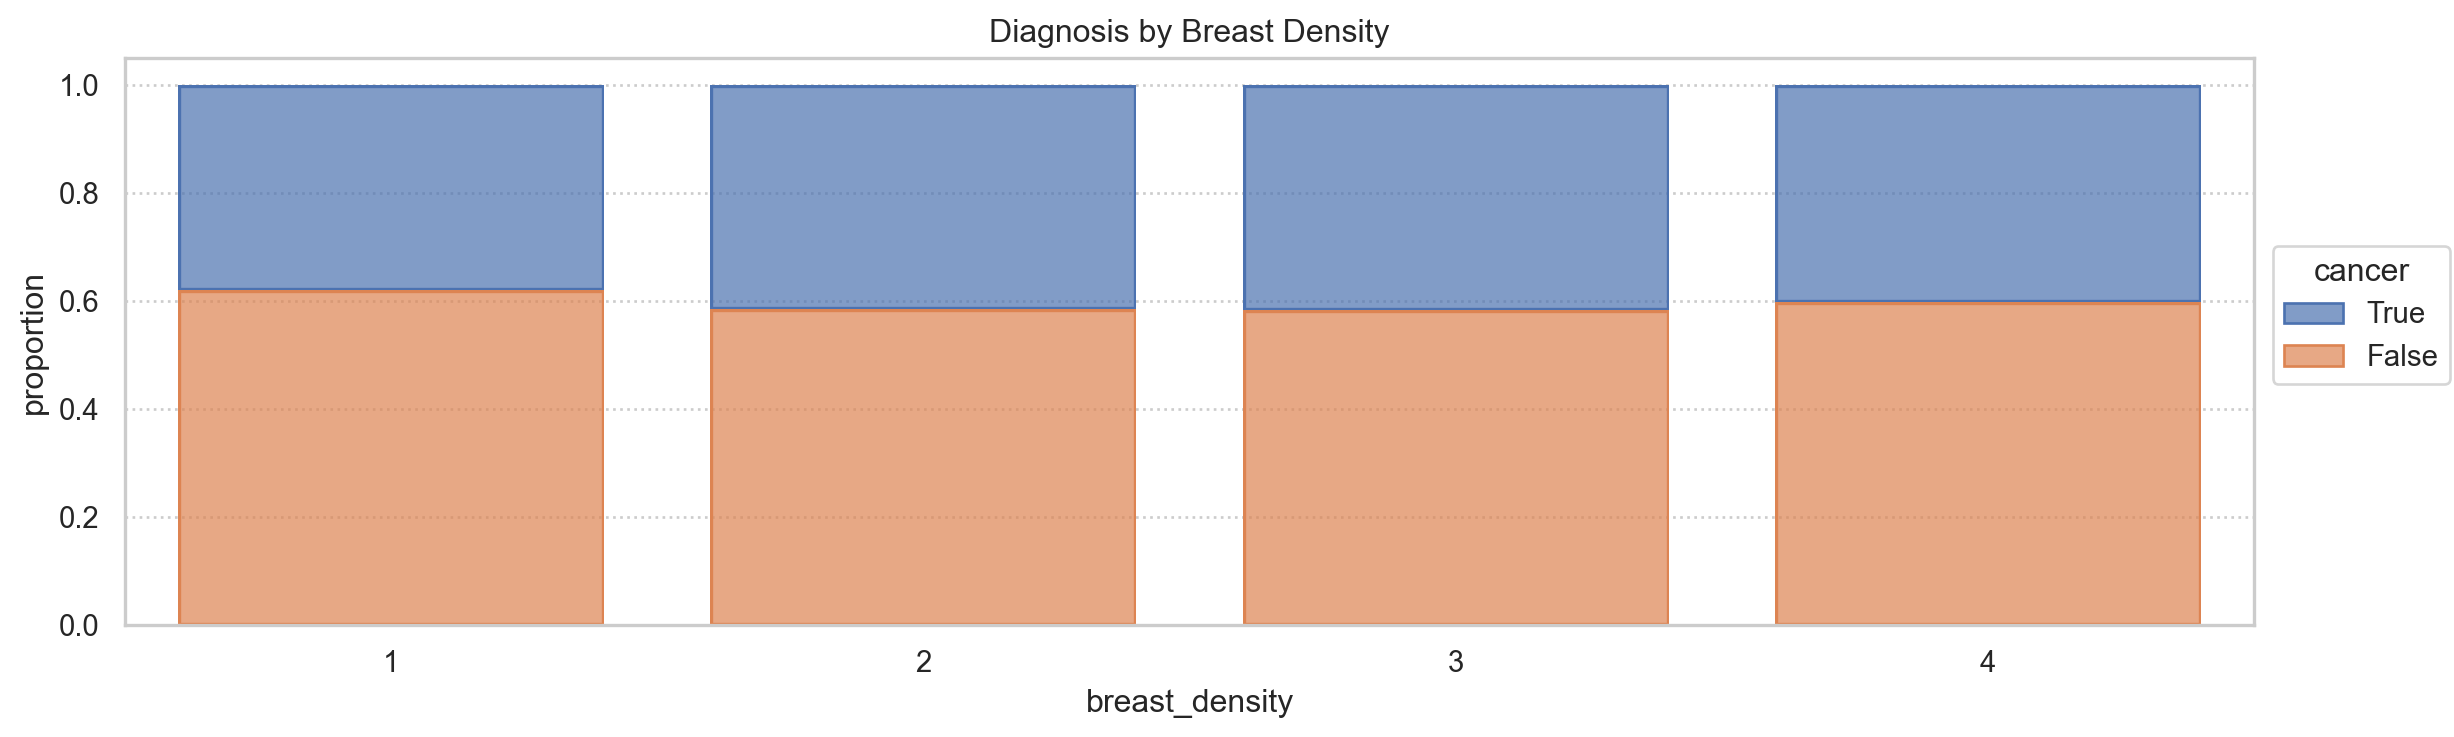

In [23]:
prop = df[['breast_density', 'cancer']].groupby(by=['breast_density']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['breast_density','cancer'])
sns.objects.Plot(prop, x='breast_density', y='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Breast Density").layout(size=(12,4), engine='tight')

In [24]:
kt = cases.stats.kendallstau(a='breast_density', b='cancer')
print(kt)



                          KendallsTau                           
                            Name | Kendall's τ
                           Value | 0.011138411035362646
                          Pvalue | 0.5382894688881223
                           Alpha | 0.05
                               A | breast_density
                               B | cancer
                               N | 3566
                        Strength | Weak




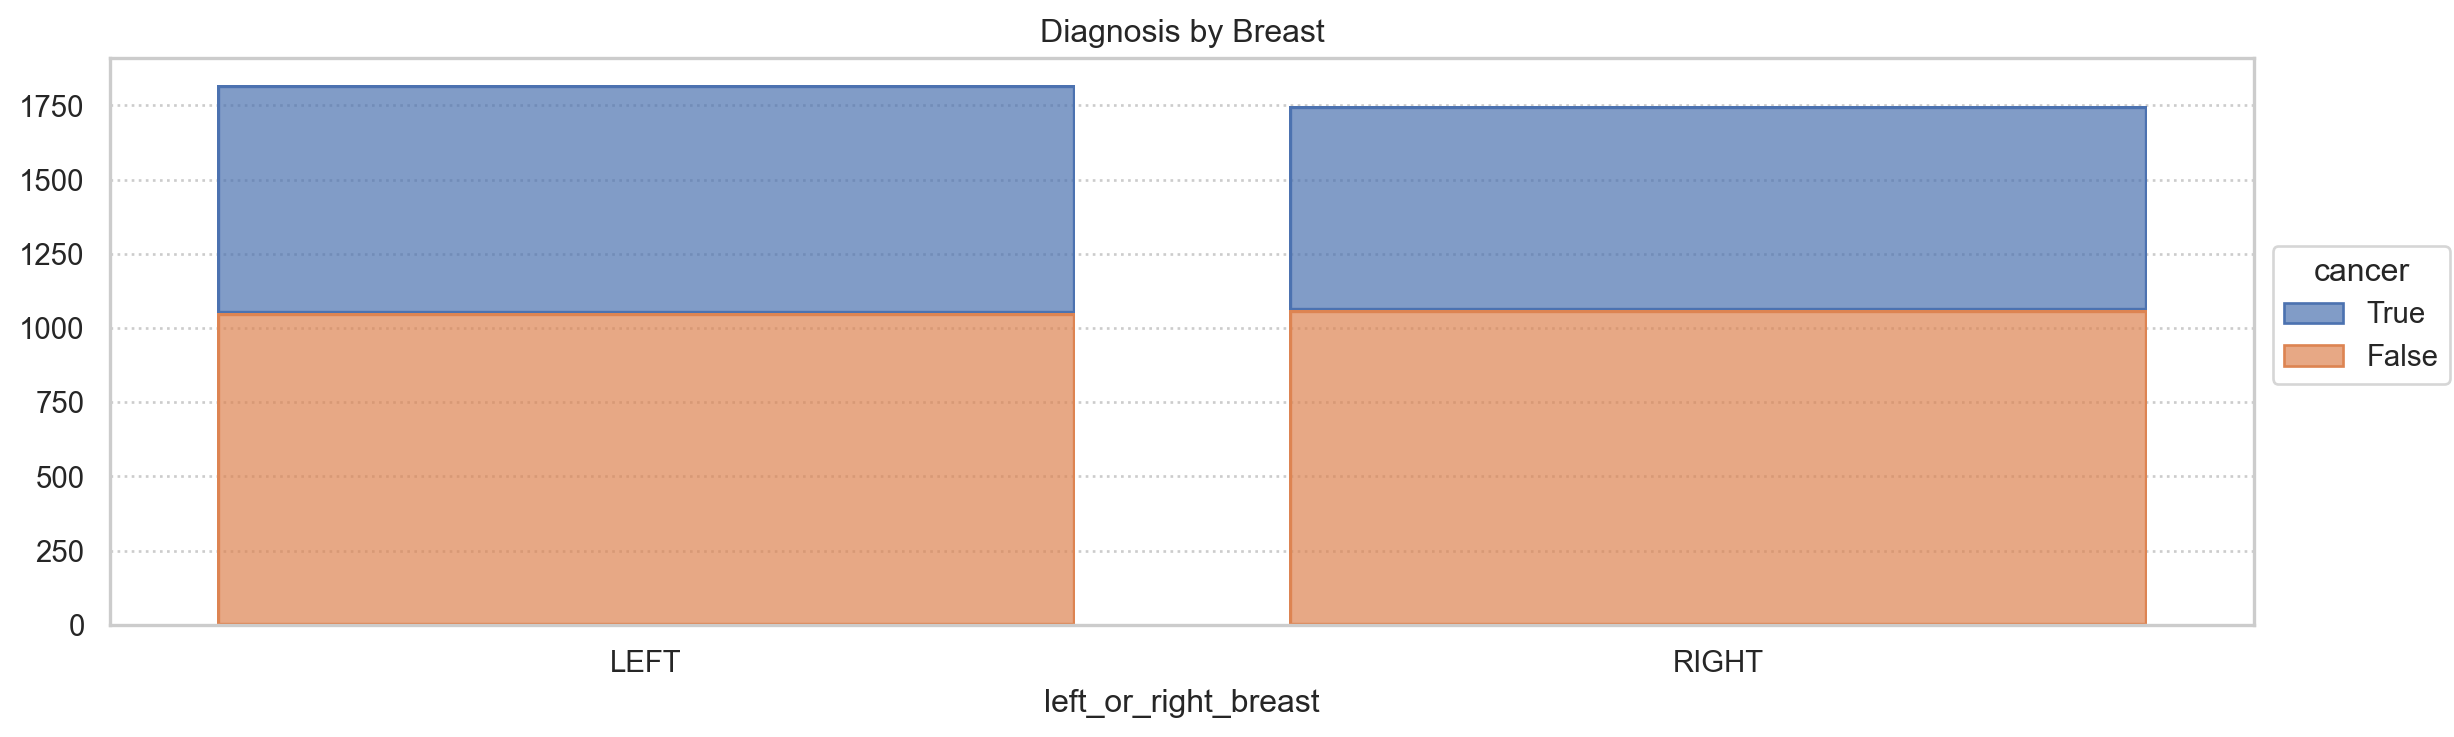

In [25]:
sns.objects.Plot(df, x='left_or_right_breast', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Breast").layout(size=(12,4), engine='tight')

In [26]:
cv = cases.stats.cramersv(a='left_or_right_breast', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.028861432861833916
                          Pvalue | 0.08480010265447133
                           Alpha | 0.05
                        Strength | Negligible
                               A | left_or_right_breast
                               B | cancer
                               N | 3566
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 2.970414906184831
                           X2dof | 1




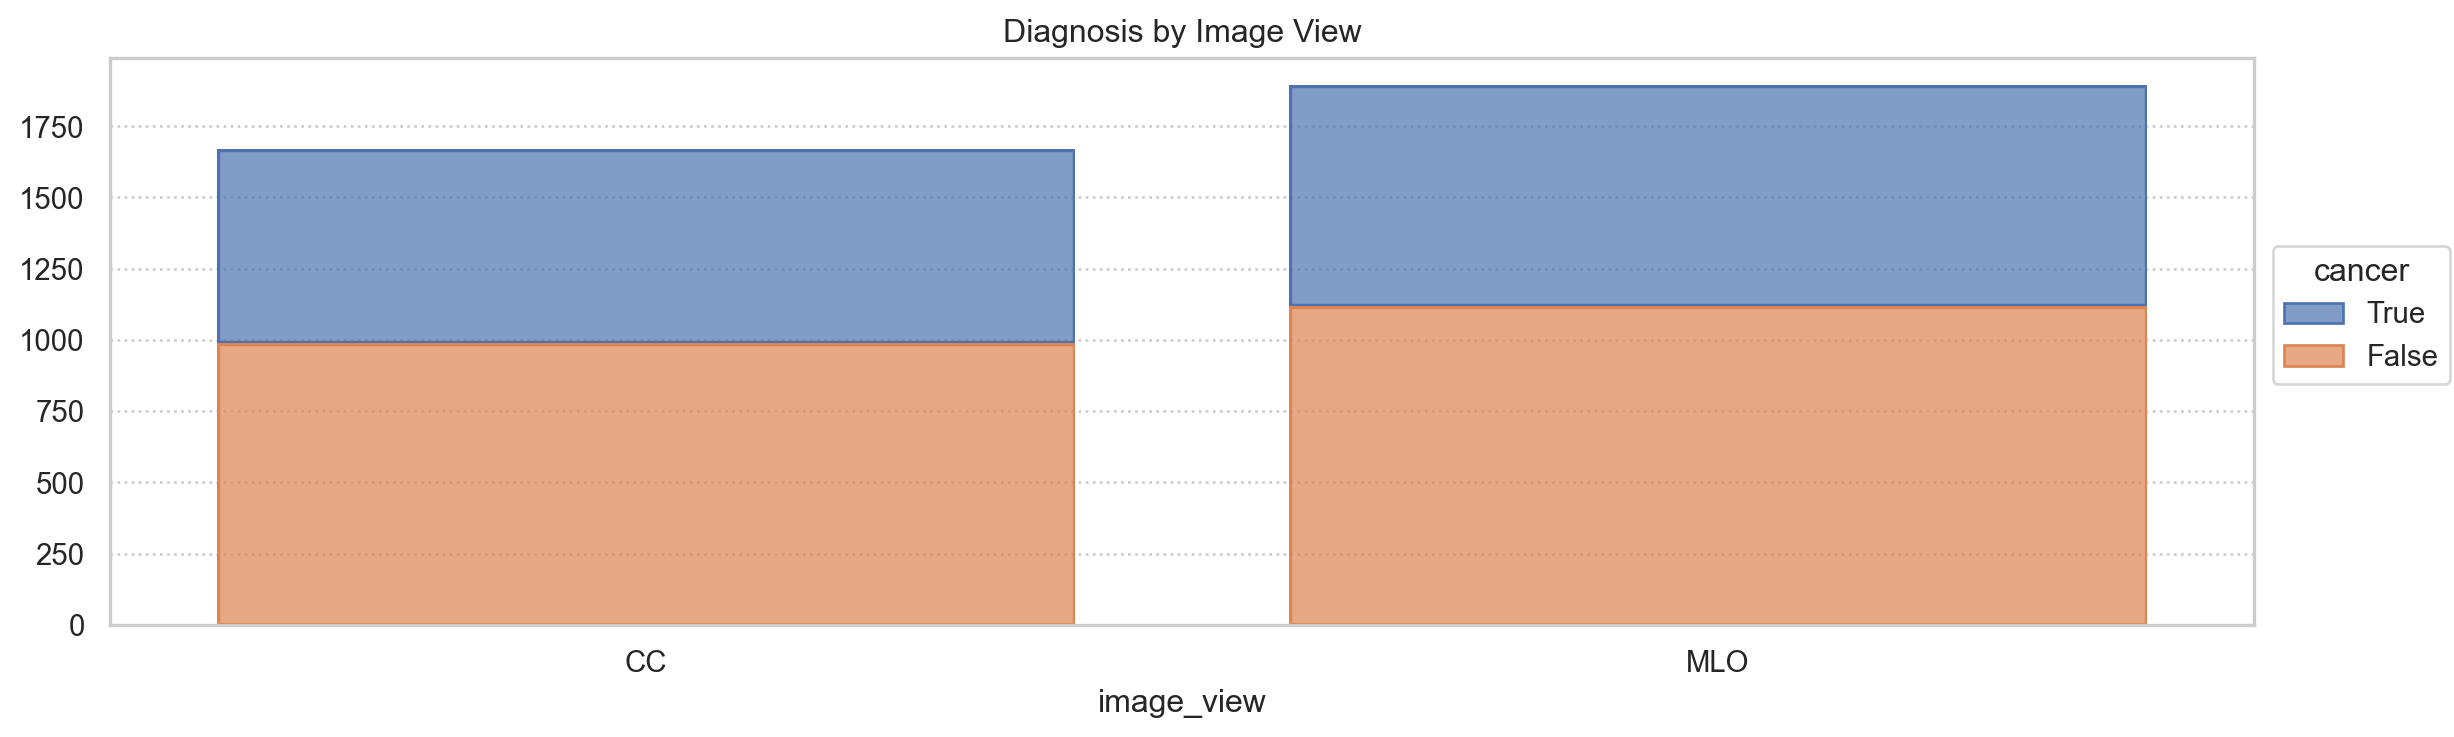

In [27]:
sns.objects.Plot(df, x='image_view', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Image View").layout(size=(12,4), engine='tight')

In [28]:
df[[ 'cancer', 'image_view']].groupby(by=['image_view']).value_counts(normalize=True).to_frame()

proportion
image_view cancer            
CC         False         0.59
           True          0.41
MLO        False         0.59
           True          0.41

In [29]:
cv = cases.stats.cramersv(a='image_view', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.0014163311721585292
                          Pvalue | 0.9325971883801198
                           Alpha | 0.05
                        Strength | Negligible
                               A | image_view
                               B | cancer
                               N | 3566
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 0.007153374565586881
                           X2dof | 1




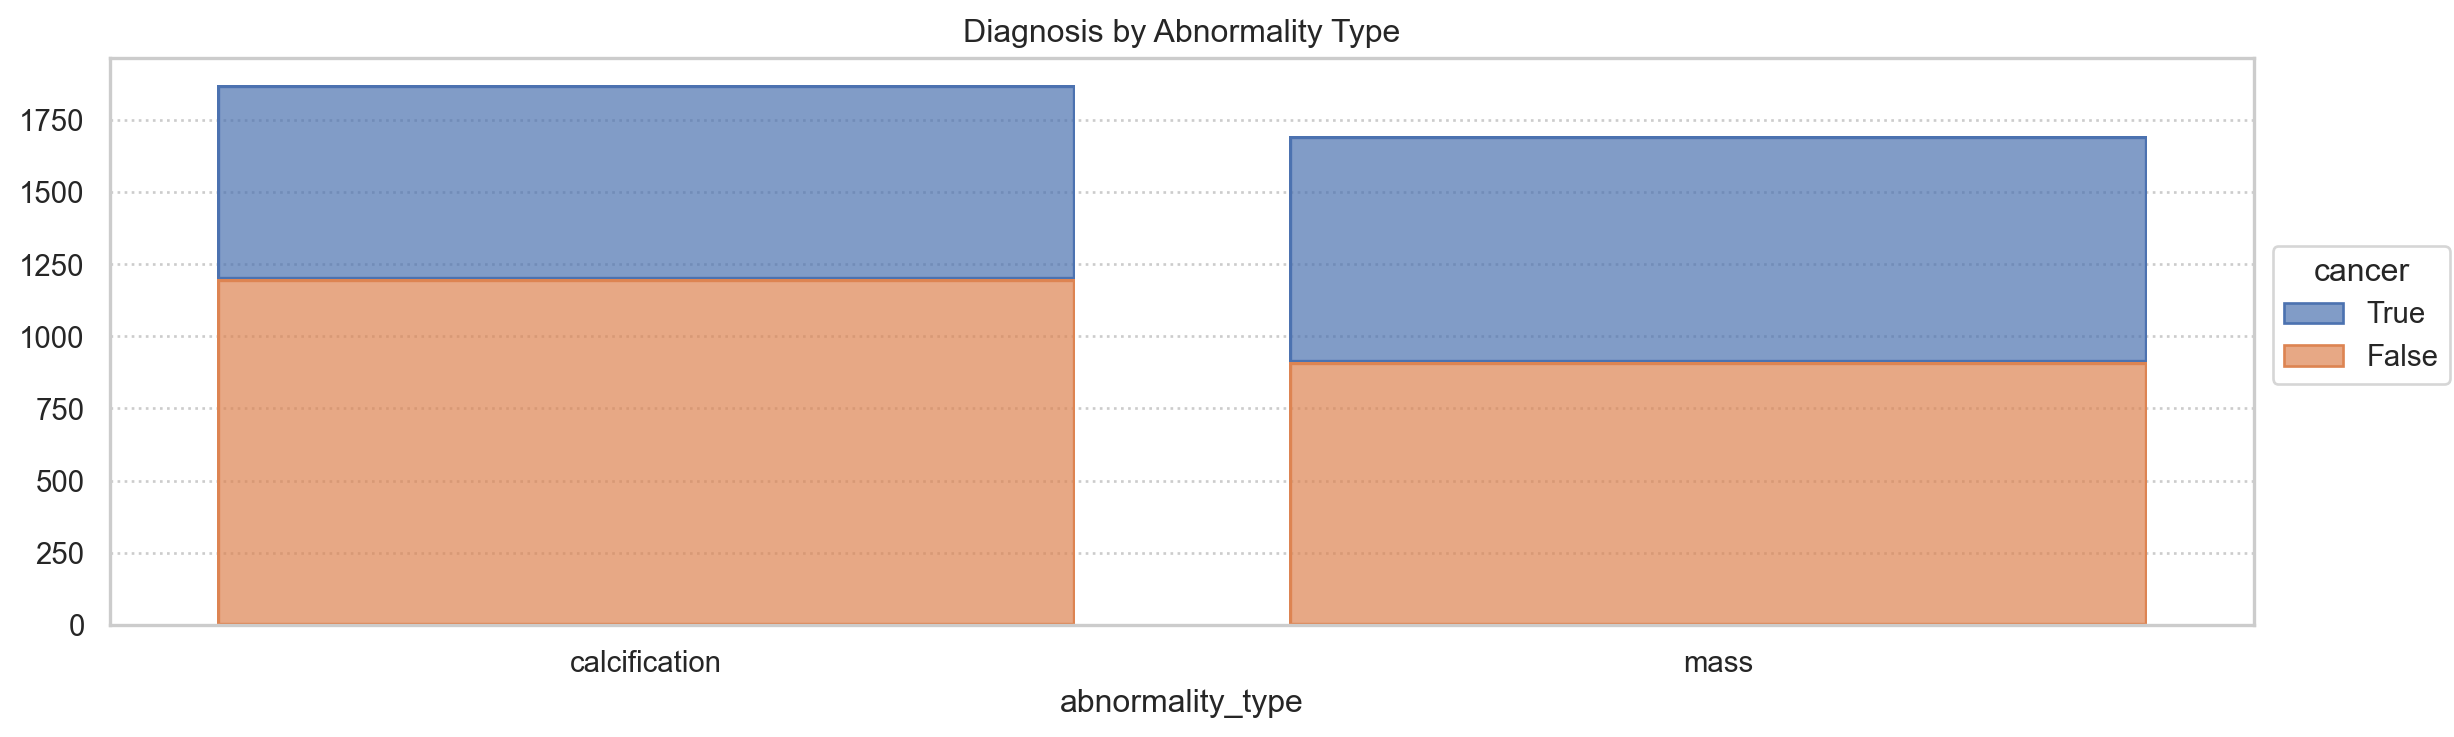

In [30]:
sns.objects.Plot(df, x='abnormality_type', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Abnormality Type").layout(size=(12,4), engine='tight')

In [31]:
df[[ 'cancer', 'abnormality_type']].groupby(by=['cancer']).value_counts(normalize=True).to_frame()

proportion
cancer abnormality_type            
False  calcification           0.57
       mass                    0.43
True   mass                    0.54
       calcification           0.46

In [32]:
cv = cases.stats.cramersv(a='abnormality_type', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.10437040964253724
                          Pvalue | 4.5880686528820935e-10
                           Alpha | 0.05
                        Strength | Small
                               A | abnormality_type
                               B | cancer
                               N | 3566
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 38.84508847031938
                           X2dof | 1




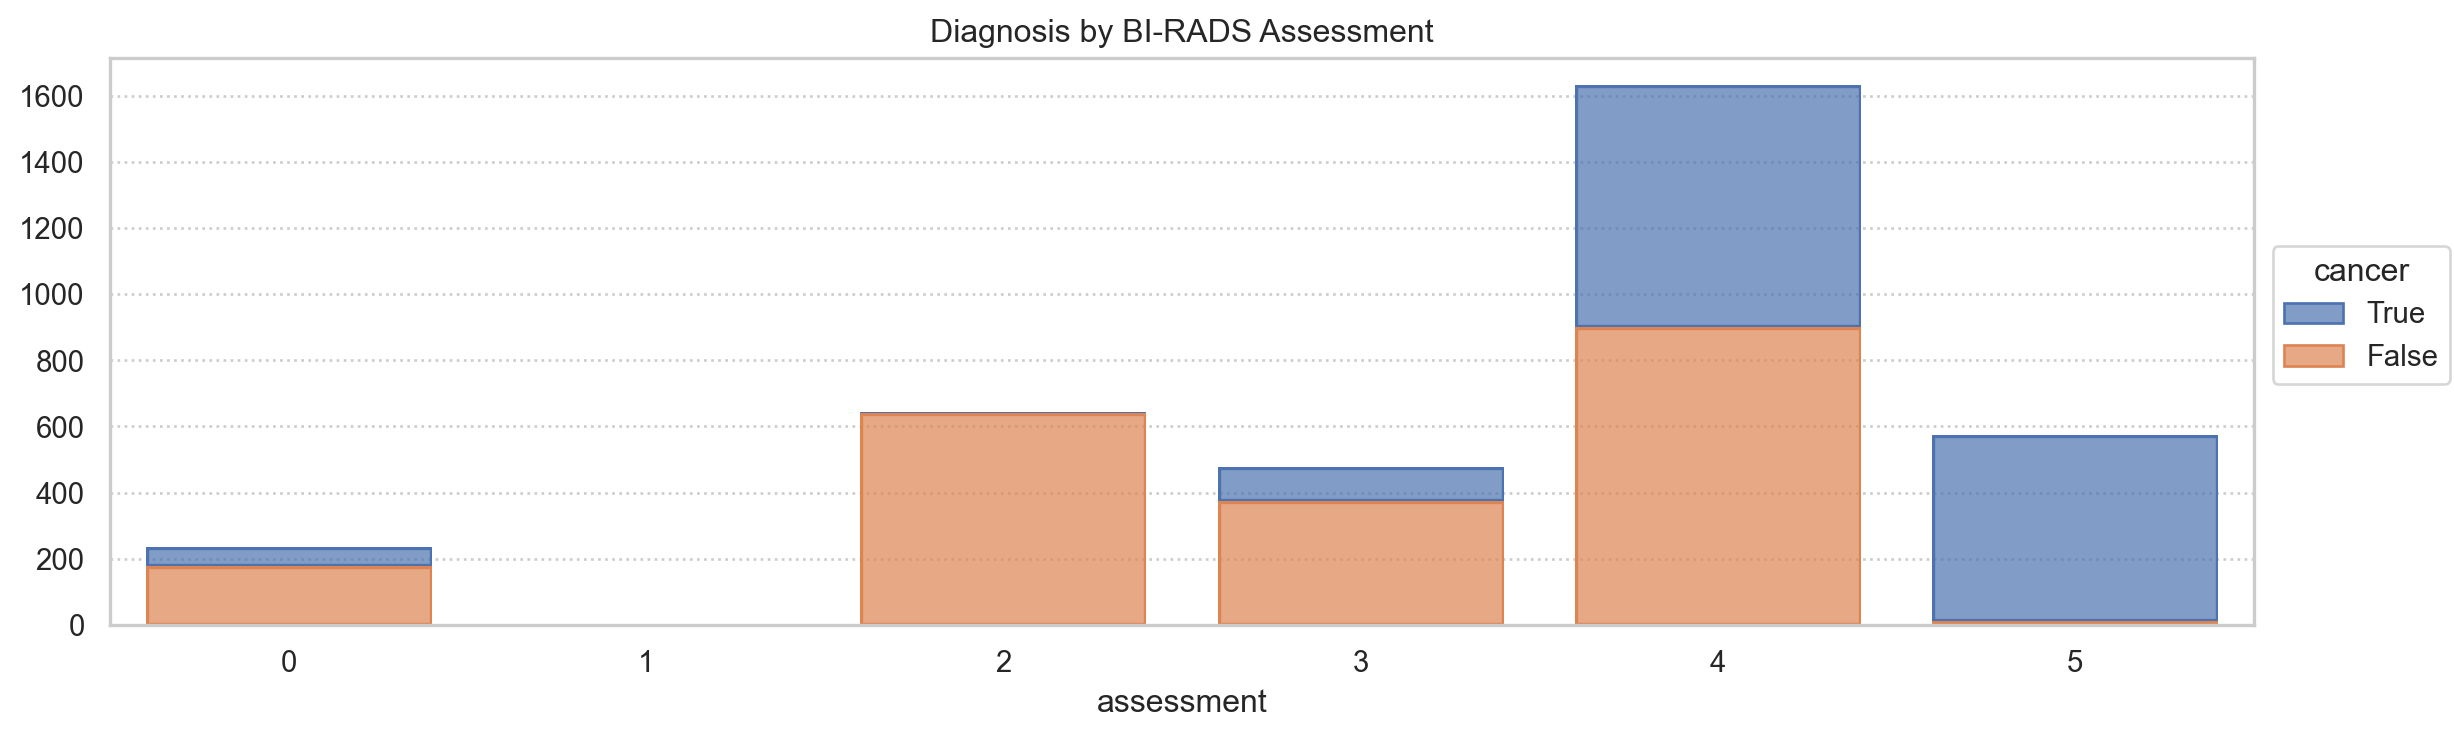

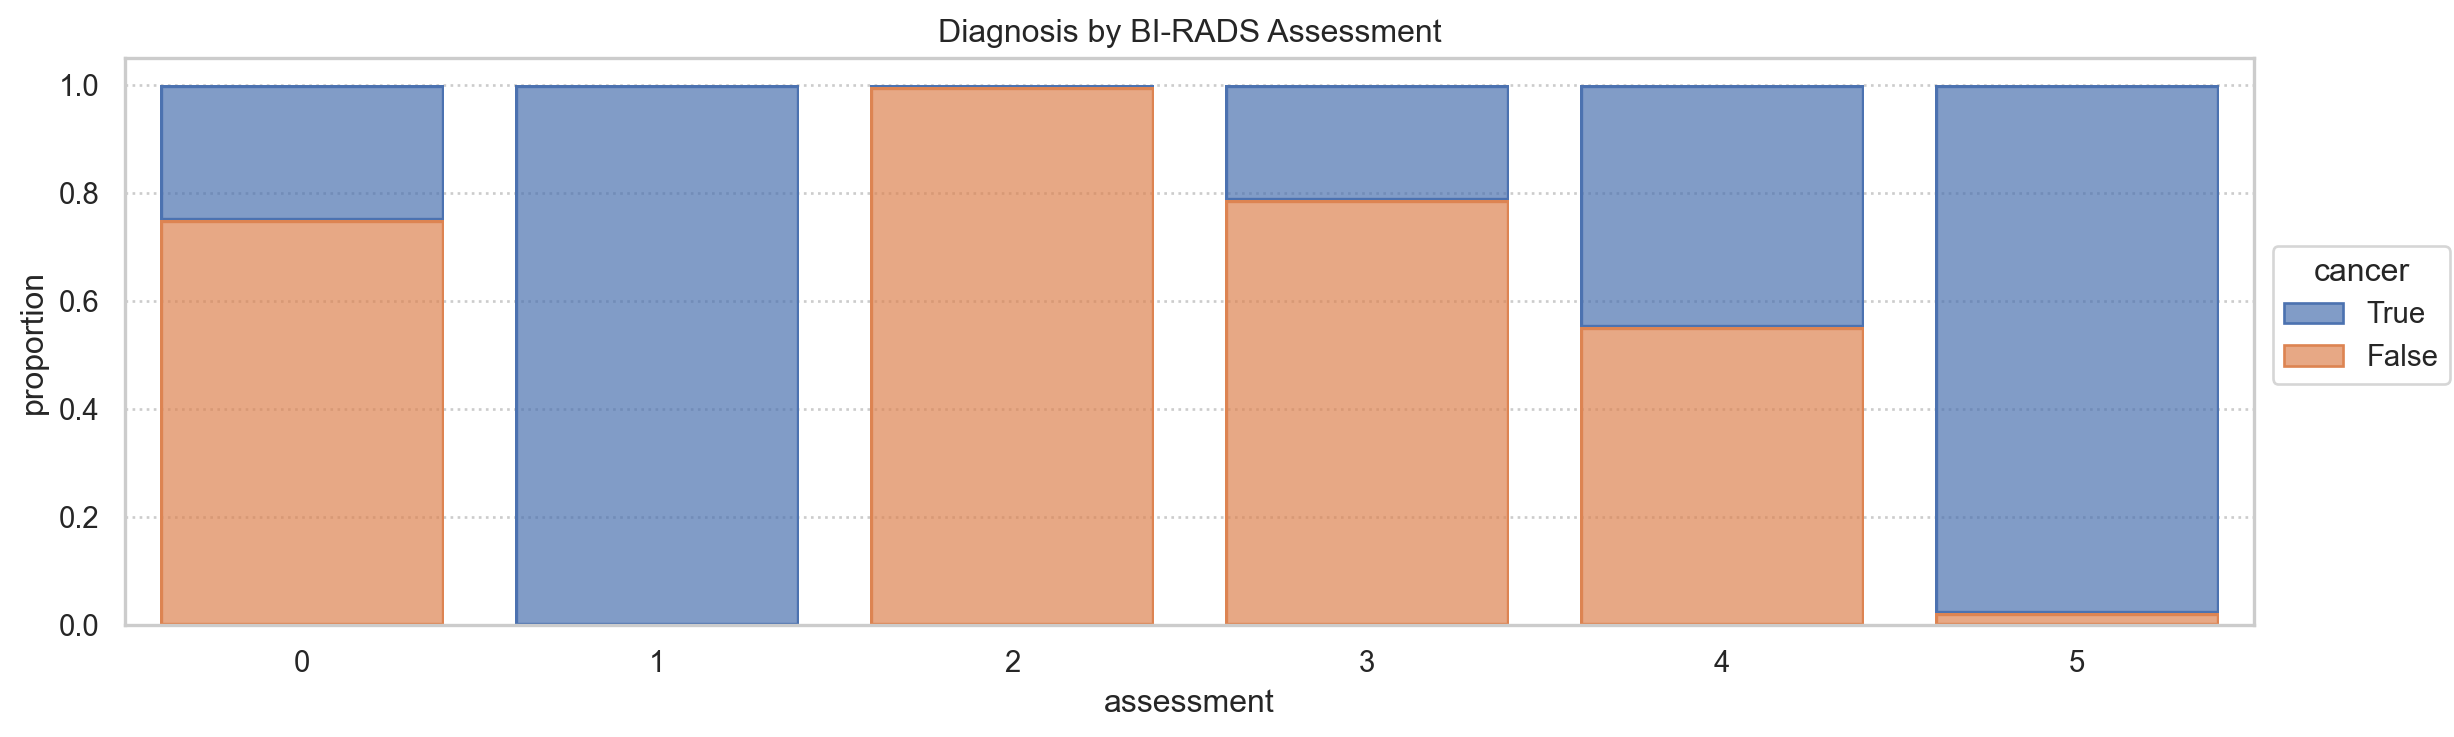

In [33]:
sns.objects.Plot(df, x='assessment', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by BI-RADS Assessment").layout(size=(12,4), engine='tight')
prop = df[['assessment', 'cancer']].groupby(by=['assessment']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['assessment','cancer'])
sns.objects.Plot(prop, x='assessment', y='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by BI-RADS Assessment").layout(size=(12,4), engine='tight')

In [34]:
counts = df[[ 'assessment', 'cancer']].groupby(by=['assessment']).value_counts(normalize=False).to_frame().sort_values(by=['assessment', 'cancer'])
prop = df[[ 'assessment', 'cancer']].groupby(by=['assessment']).value_counts(normalize=True).to_frame().sort_values(by=['assessment', 'cancer'])
pd.concat([counts, prop], axis=1)

count  proportion
assessment cancer                   
0          False     177        0.75
           True       59        0.25
1          False       0        0.00
           True        3        1.00
2          False     642        1.00
           True        2        0.00
3          False     375        0.79
           True      102        0.21
4          False     902        0.55
           True      731        0.45
5          False      13        0.02
           True      560        0.98

In [35]:
kt = cases.stats.kendallstau(a='assessment', b='cancer')
print(kt)



                          KendallsTau                           
                            Name | Kendall's τ
                           Value | 0.5994799138998625
                          Pvalue | 1.4696313517612682e-244
                           Alpha | 0.05
                               A | assessment
                               B | cancer
                               N | 3566
                        Strength | Strong




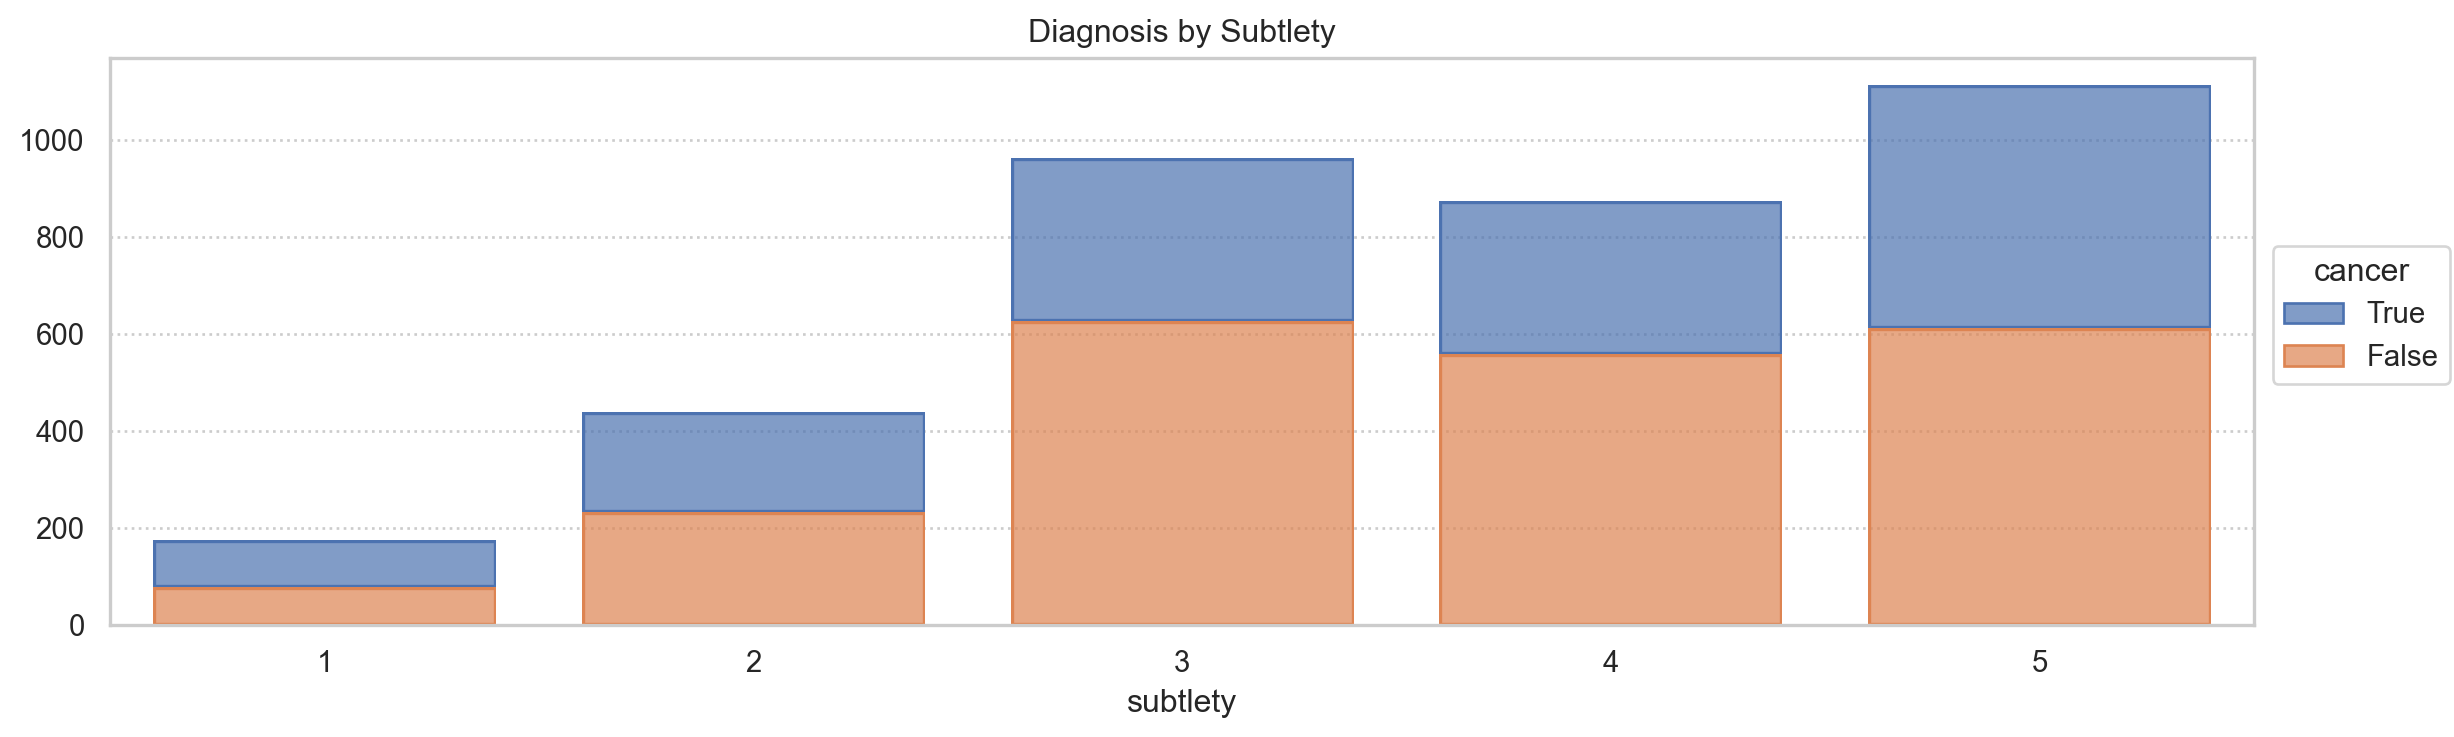

In [36]:
sns.objects.Plot(df, x='subtlety', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Subtlety").layout(size=(12,4), engine='tight')

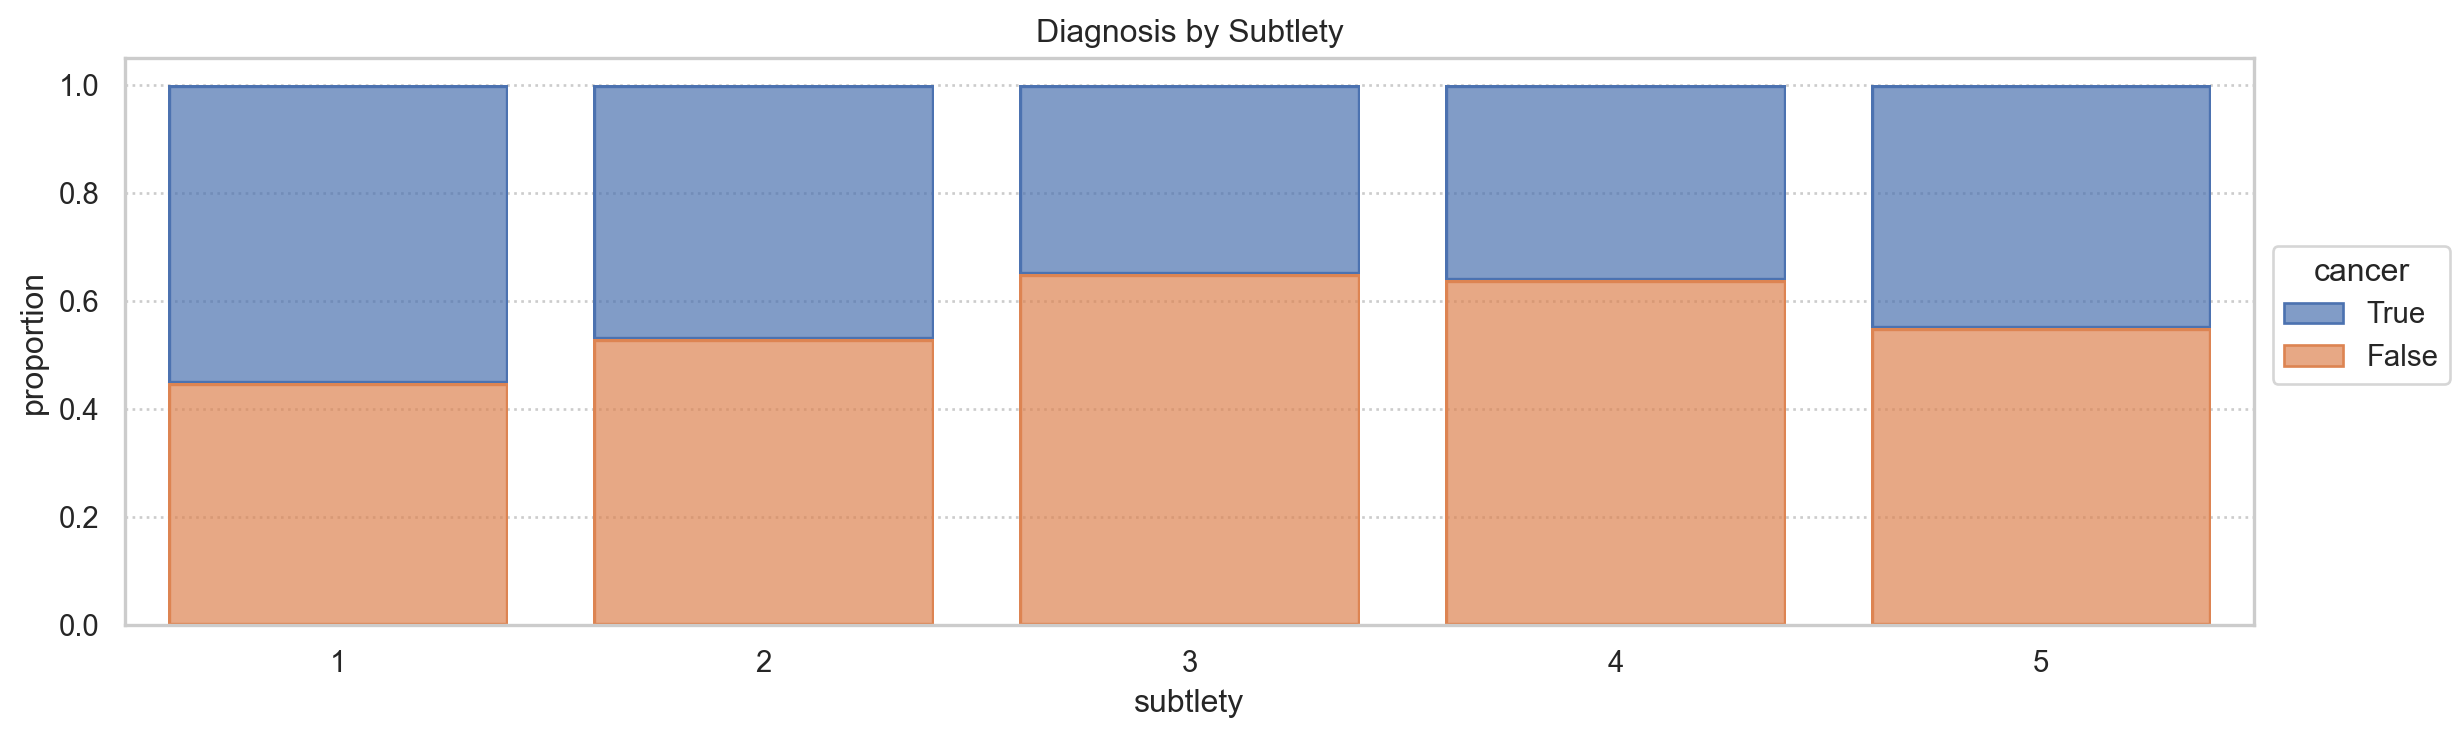

In [37]:
prop = df[['subtlety', 'cancer']].groupby(by=['subtlety']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['subtlety','cancer'])
sns.objects.Plot(prop, x='subtlety', y='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Subtlety").layout(size=(12,4), engine='tight')

In [38]:
counts = df[[ 'subtlety', 'cancer']].groupby(by=['subtlety']).value_counts(normalize=False).to_frame().sort_values(by=['subtlety', 'cancer'])
prop = df[[ 'subtlety', 'cancer']].groupby(by=['subtlety']).value_counts(normalize=True).to_frame().sort_values(by=['subtlety', 'cancer'])
pd.concat([counts, prop], axis=1)

count  proportion
subtlety cancer                   
1        False      78        0.45
         True       96        0.55
2        False     232        0.53
         True      207        0.47
3        False     627        0.65
         True      337        0.35
4        False     559        0.64
         True      316        0.36
5        False     613        0.55
         True      501        0.45

In [39]:
kt = cases.stats.kendallstau(a='subtlety', b='cancer')
print(kt)



                          KendallsTau                           
                            Name | Kendall's τ
                           Value | 0.003196827770471352
                          Pvalue | 0.8618112089236021
                           Alpha | 0.05
                               A | subtlety
                               B | cancer
                               N | 3566
                        Strength | Weak




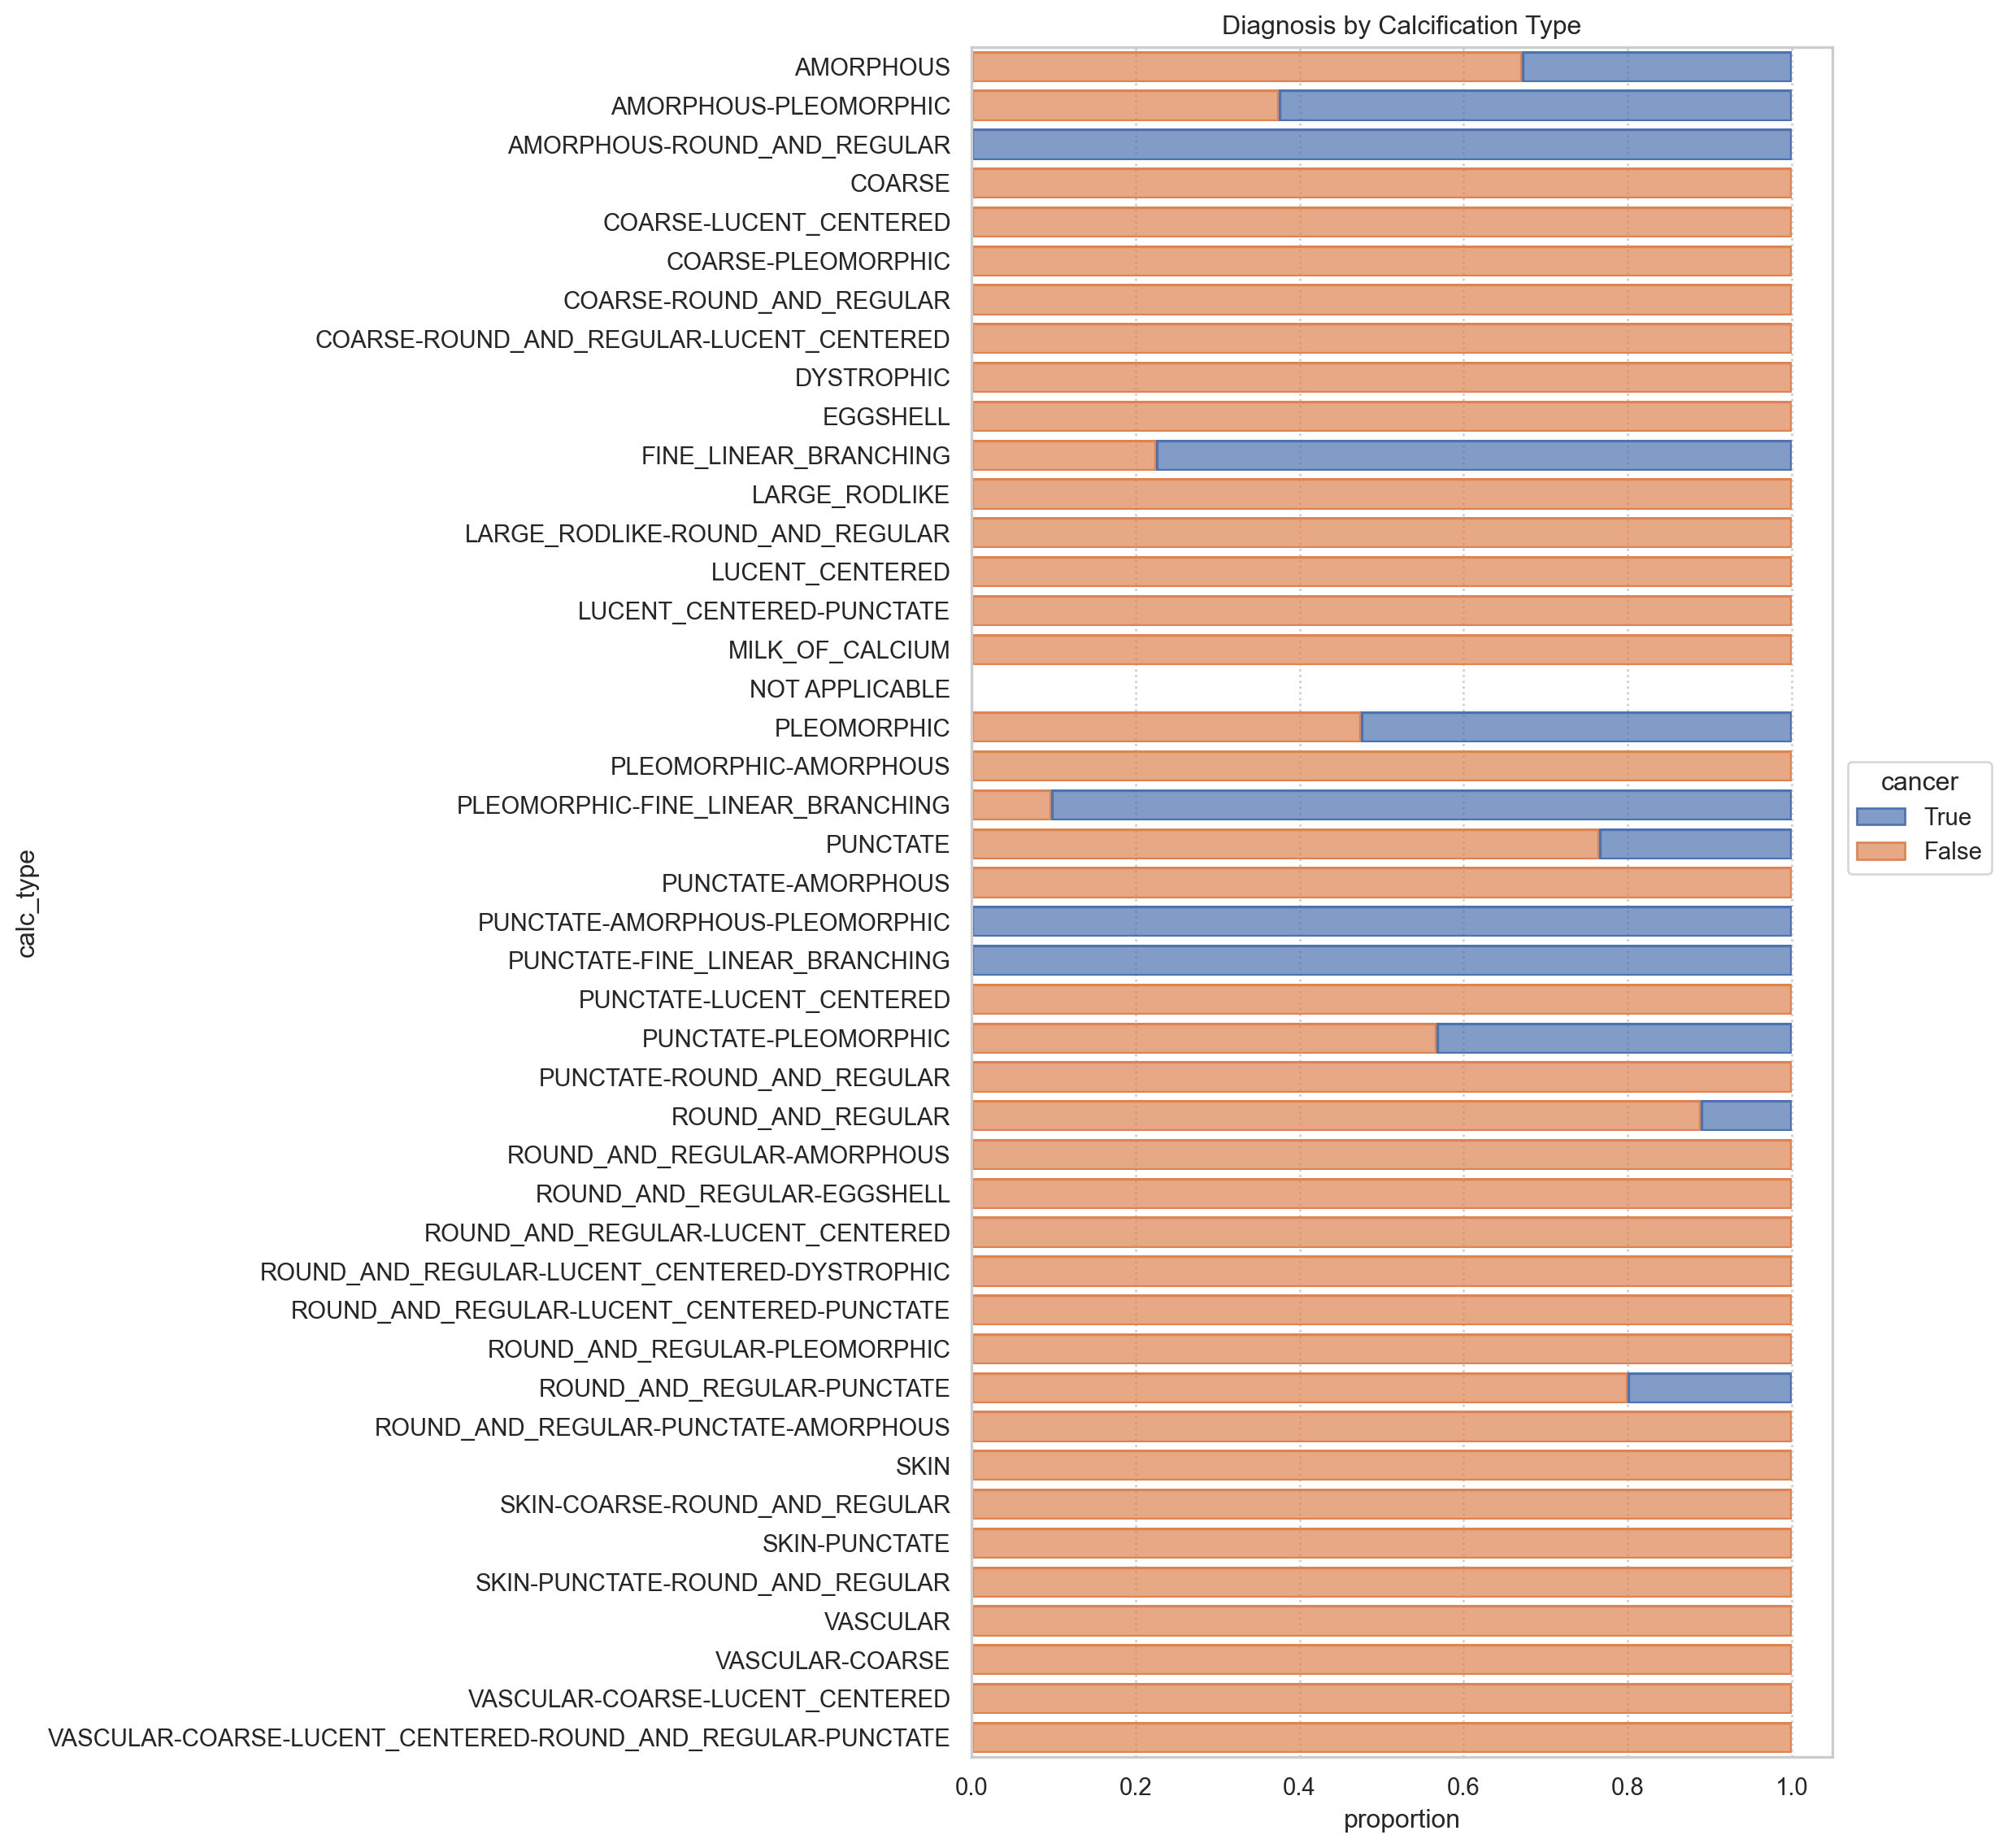

In [40]:
df_calc = calc.as_df()
prop = df_calc[['calc_type', 'cancer']].groupby(by=['calc_type']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['calc_type','cancer'])
sns.objects.Plot(prop, y='calc_type', x='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Calcification Type").layout(size=(12,12), engine='tight')

In [41]:
cv = calc.stats.cramersv(a='calc_type', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.5363368552127653
                          Pvalue | 2.078377585363777e-87
                           Alpha | 0.05
                        Strength | Large
                               A | calc_type
                               B | cancer
                               N | 1872
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 538.4943200698192
                           X2dof | 42




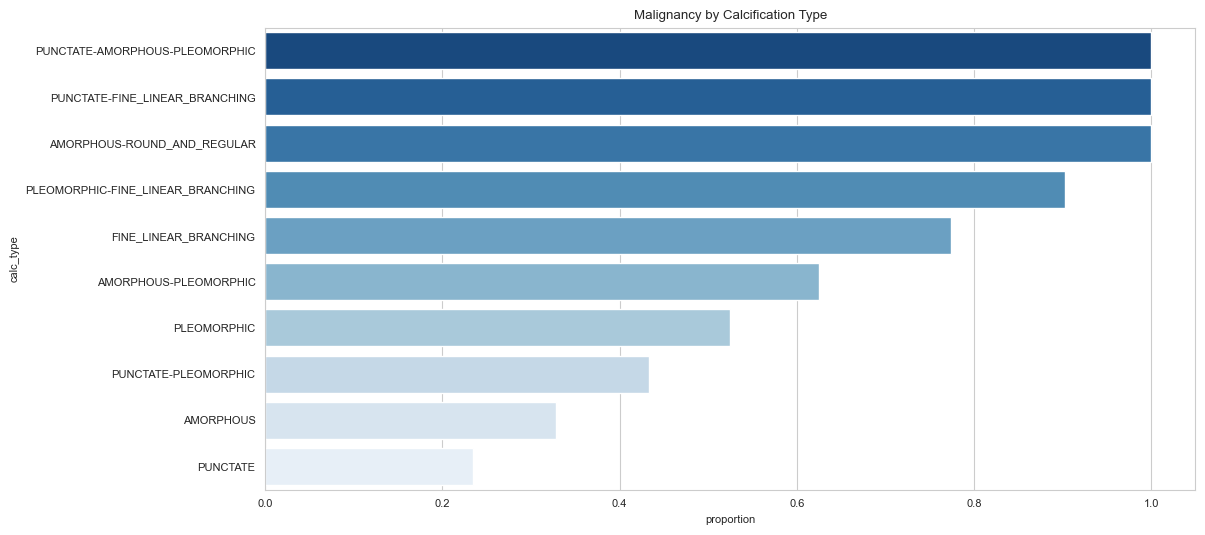

In [42]:
fig, ax = plt.subplots(figsize=(12,6))
calc_types = cases.get_most_malignant_calc(x='calc_type', n=10)
calc.plot.barplot(data=calc_types, y='calc_type', x='proportion', title='Malignancy by Calcification Type', ax=ax)

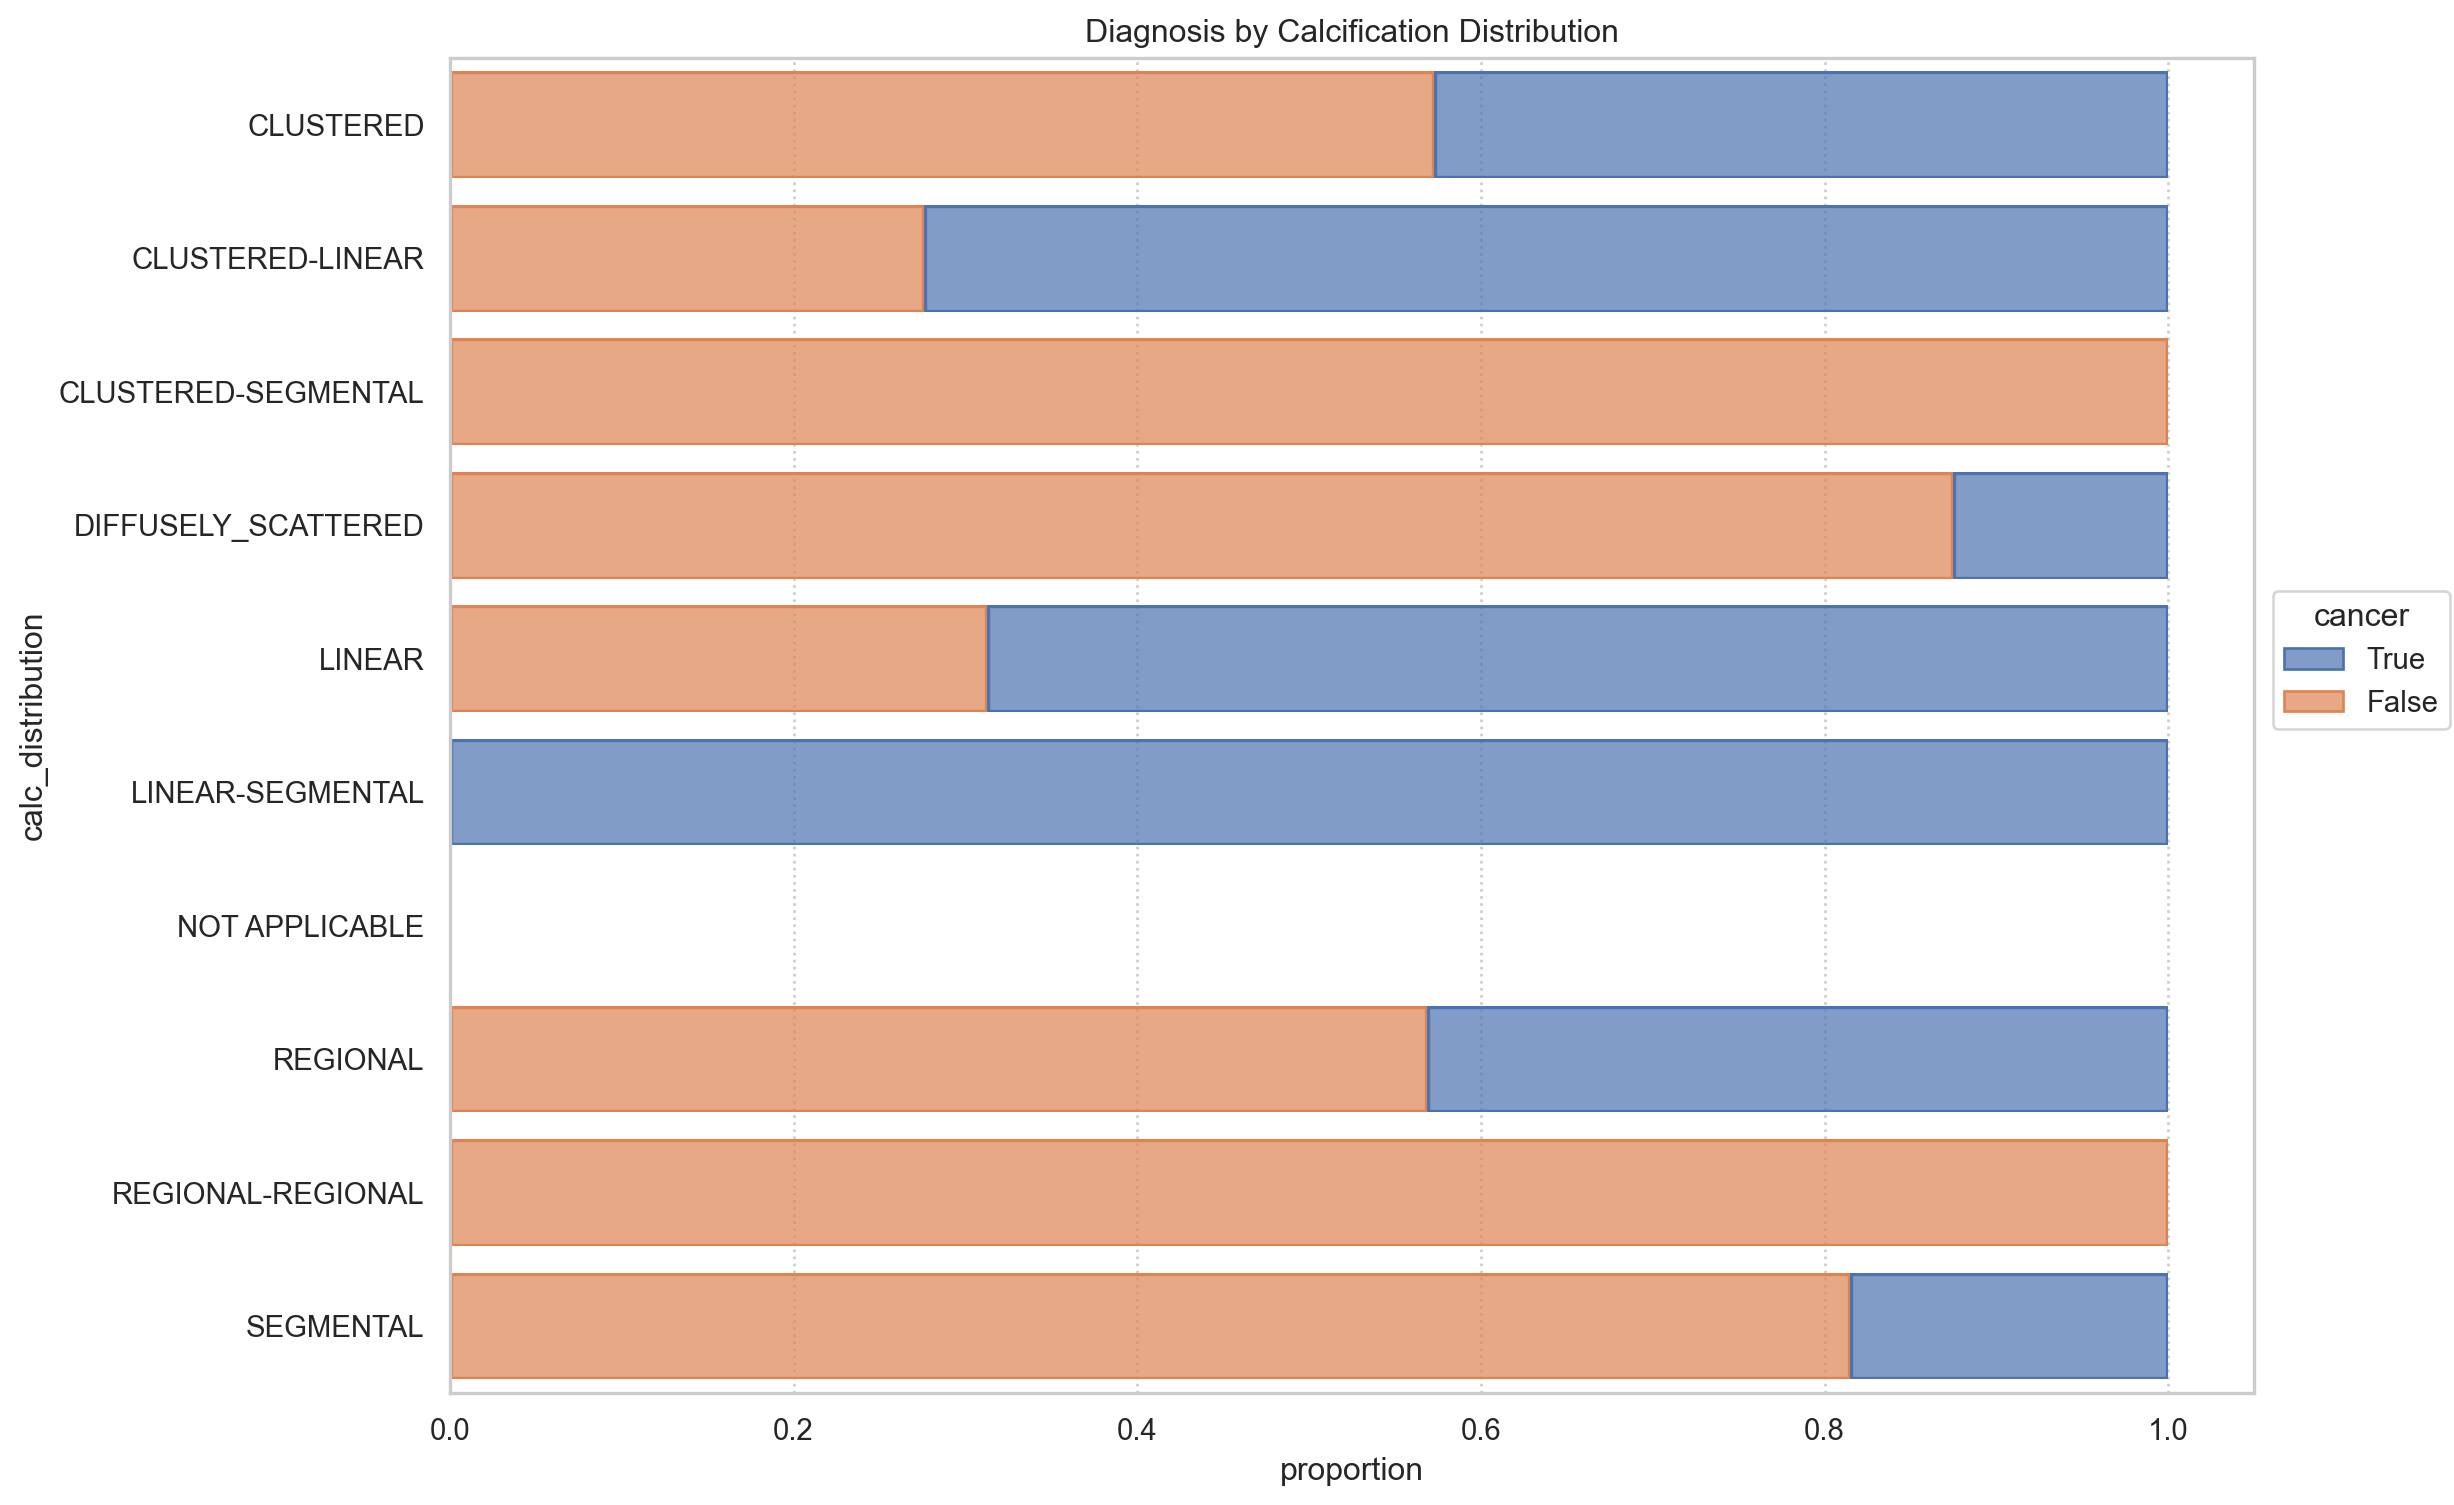

In [43]:
df_calc = calc.as_df()
prop = df_calc[['calc_distribution', 'cancer']].groupby(by=['calc_distribution']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['calc_distribution','cancer'])
sns.objects.Plot(prop, y='calc_distribution', x='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Calcification Distribution").layout(size=(12,8), engine='tight')

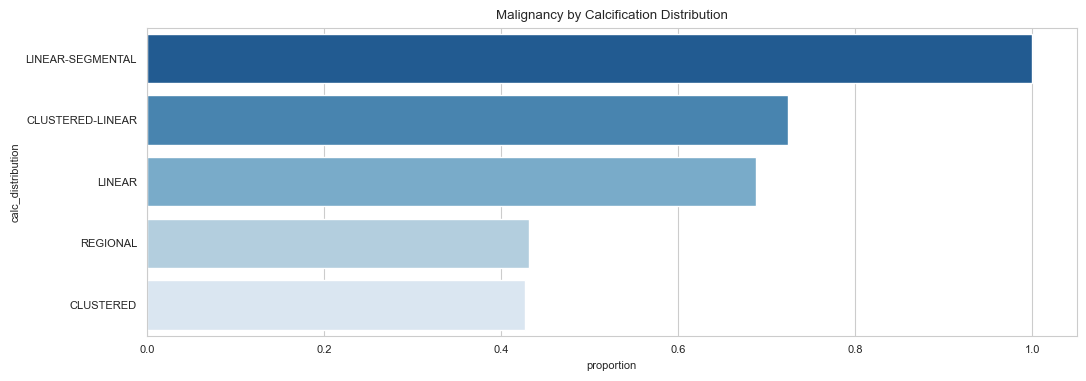

In [44]:
fig, ax = plt.subplots(figsize=(12,4))
calc_types = cases.get_most_malignant_calc(x='calc_distribution', n=5)
calc.plot.barplot(data=calc_types, y='calc_distribution', x='proportion', title='Malignancy by Calcification Distribution', ax=ax)

In [45]:
cv = calc.stats.cramersv(a='calc_distribution', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.32634130163729136
                          Pvalue | 8.693260459198279e-39
                           Alpha | 0.05
                        Strength | Moderate
                               A | calc_distribution
                               B | cancer
                               N | 1872
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 199.36546372889003
                           X2dof | 8




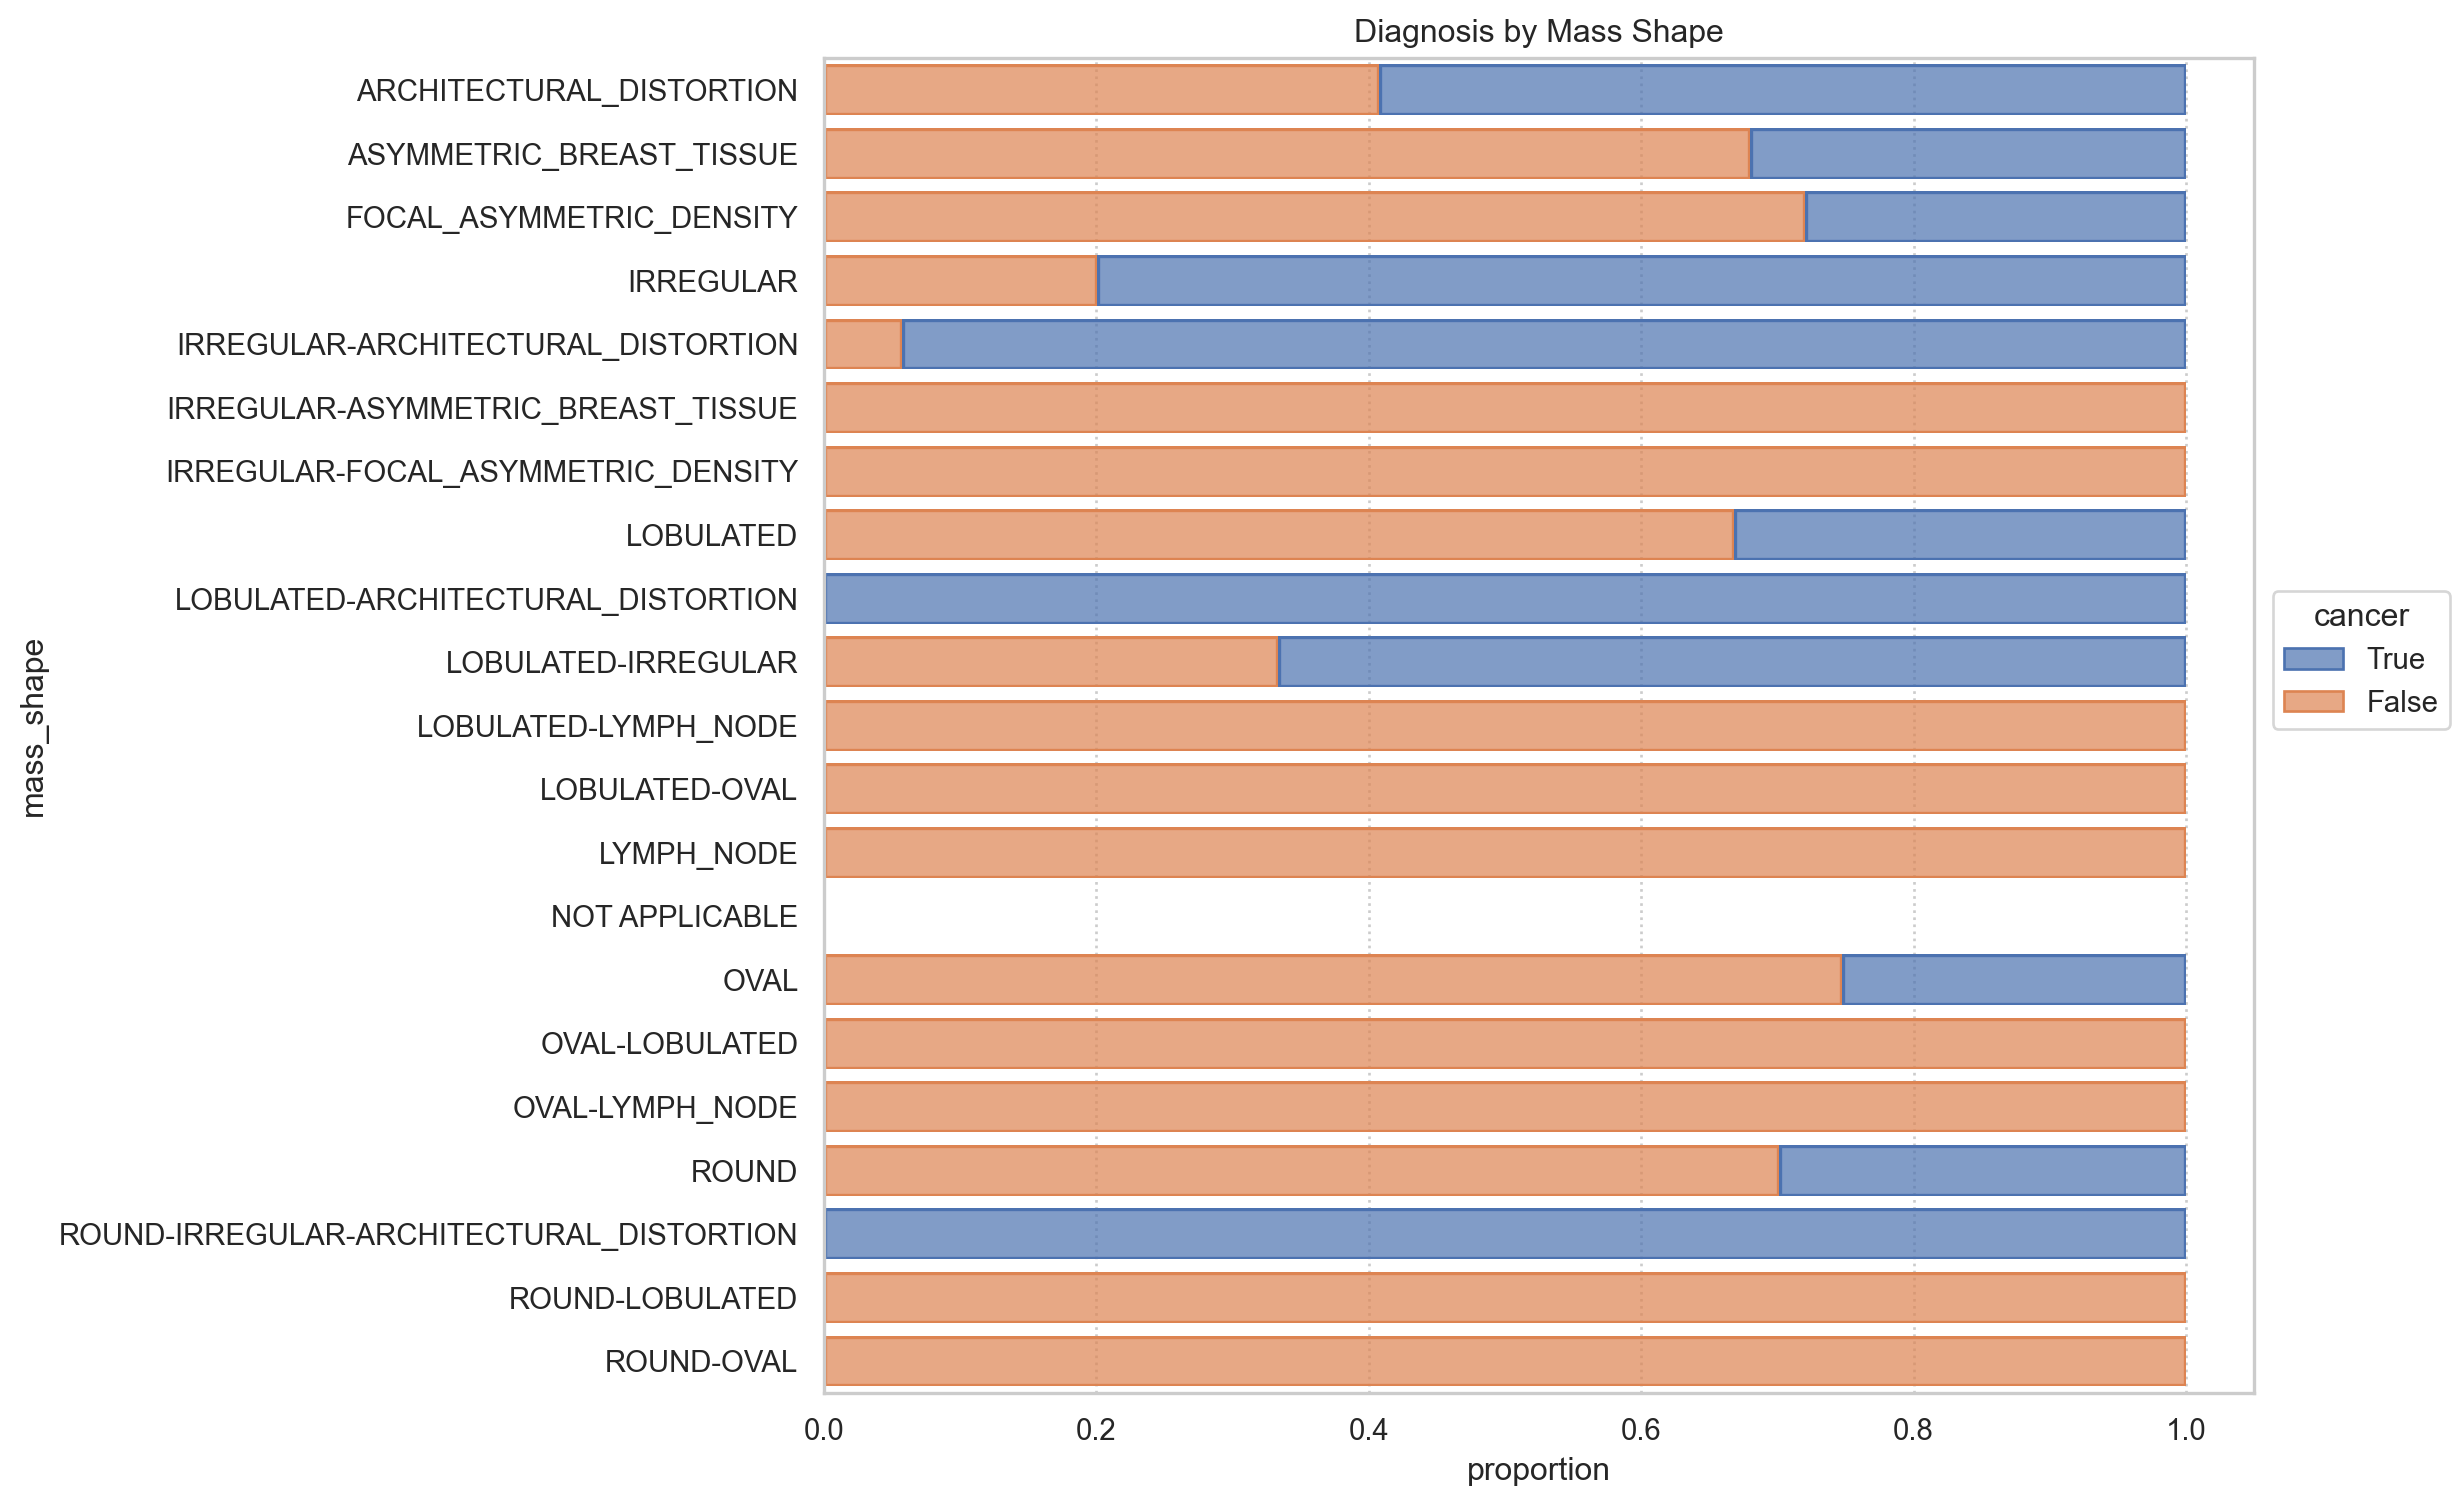

In [46]:
df_mass = mass.as_df()
prop = df_mass[['mass_shape', 'cancer']].groupby(by=['mass_shape']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['mass_shape','cancer'])
sns.objects.Plot(prop, y='mass_shape', x='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Mass Shape").layout(size=(12,8), engine='tight')

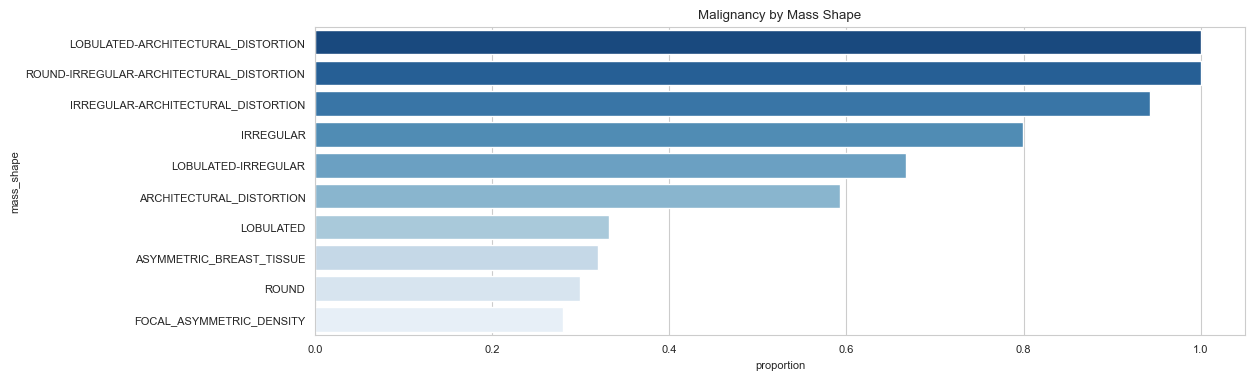

In [47]:
fig, ax = plt.subplots(figsize=(12,4))
mass_shapes = cases.get_most_malignant_mass(x='mass_shape', n=10)
mass.plot.barplot(data=mass_shapes, y='mass_shape', x='proportion', title='Malignancy by Mass Shape', ax=ax)

In [48]:
cv = mass.stats.cramersv(a='mass_shape', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.510182454781321
                          Pvalue | 1.297593104510473e-81
                           Alpha | 0.05
                        Strength | Large
                               A | mass_shape
                               B | cancer
                               N | 1694
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 440.9247163603807
                           X2dof | 19




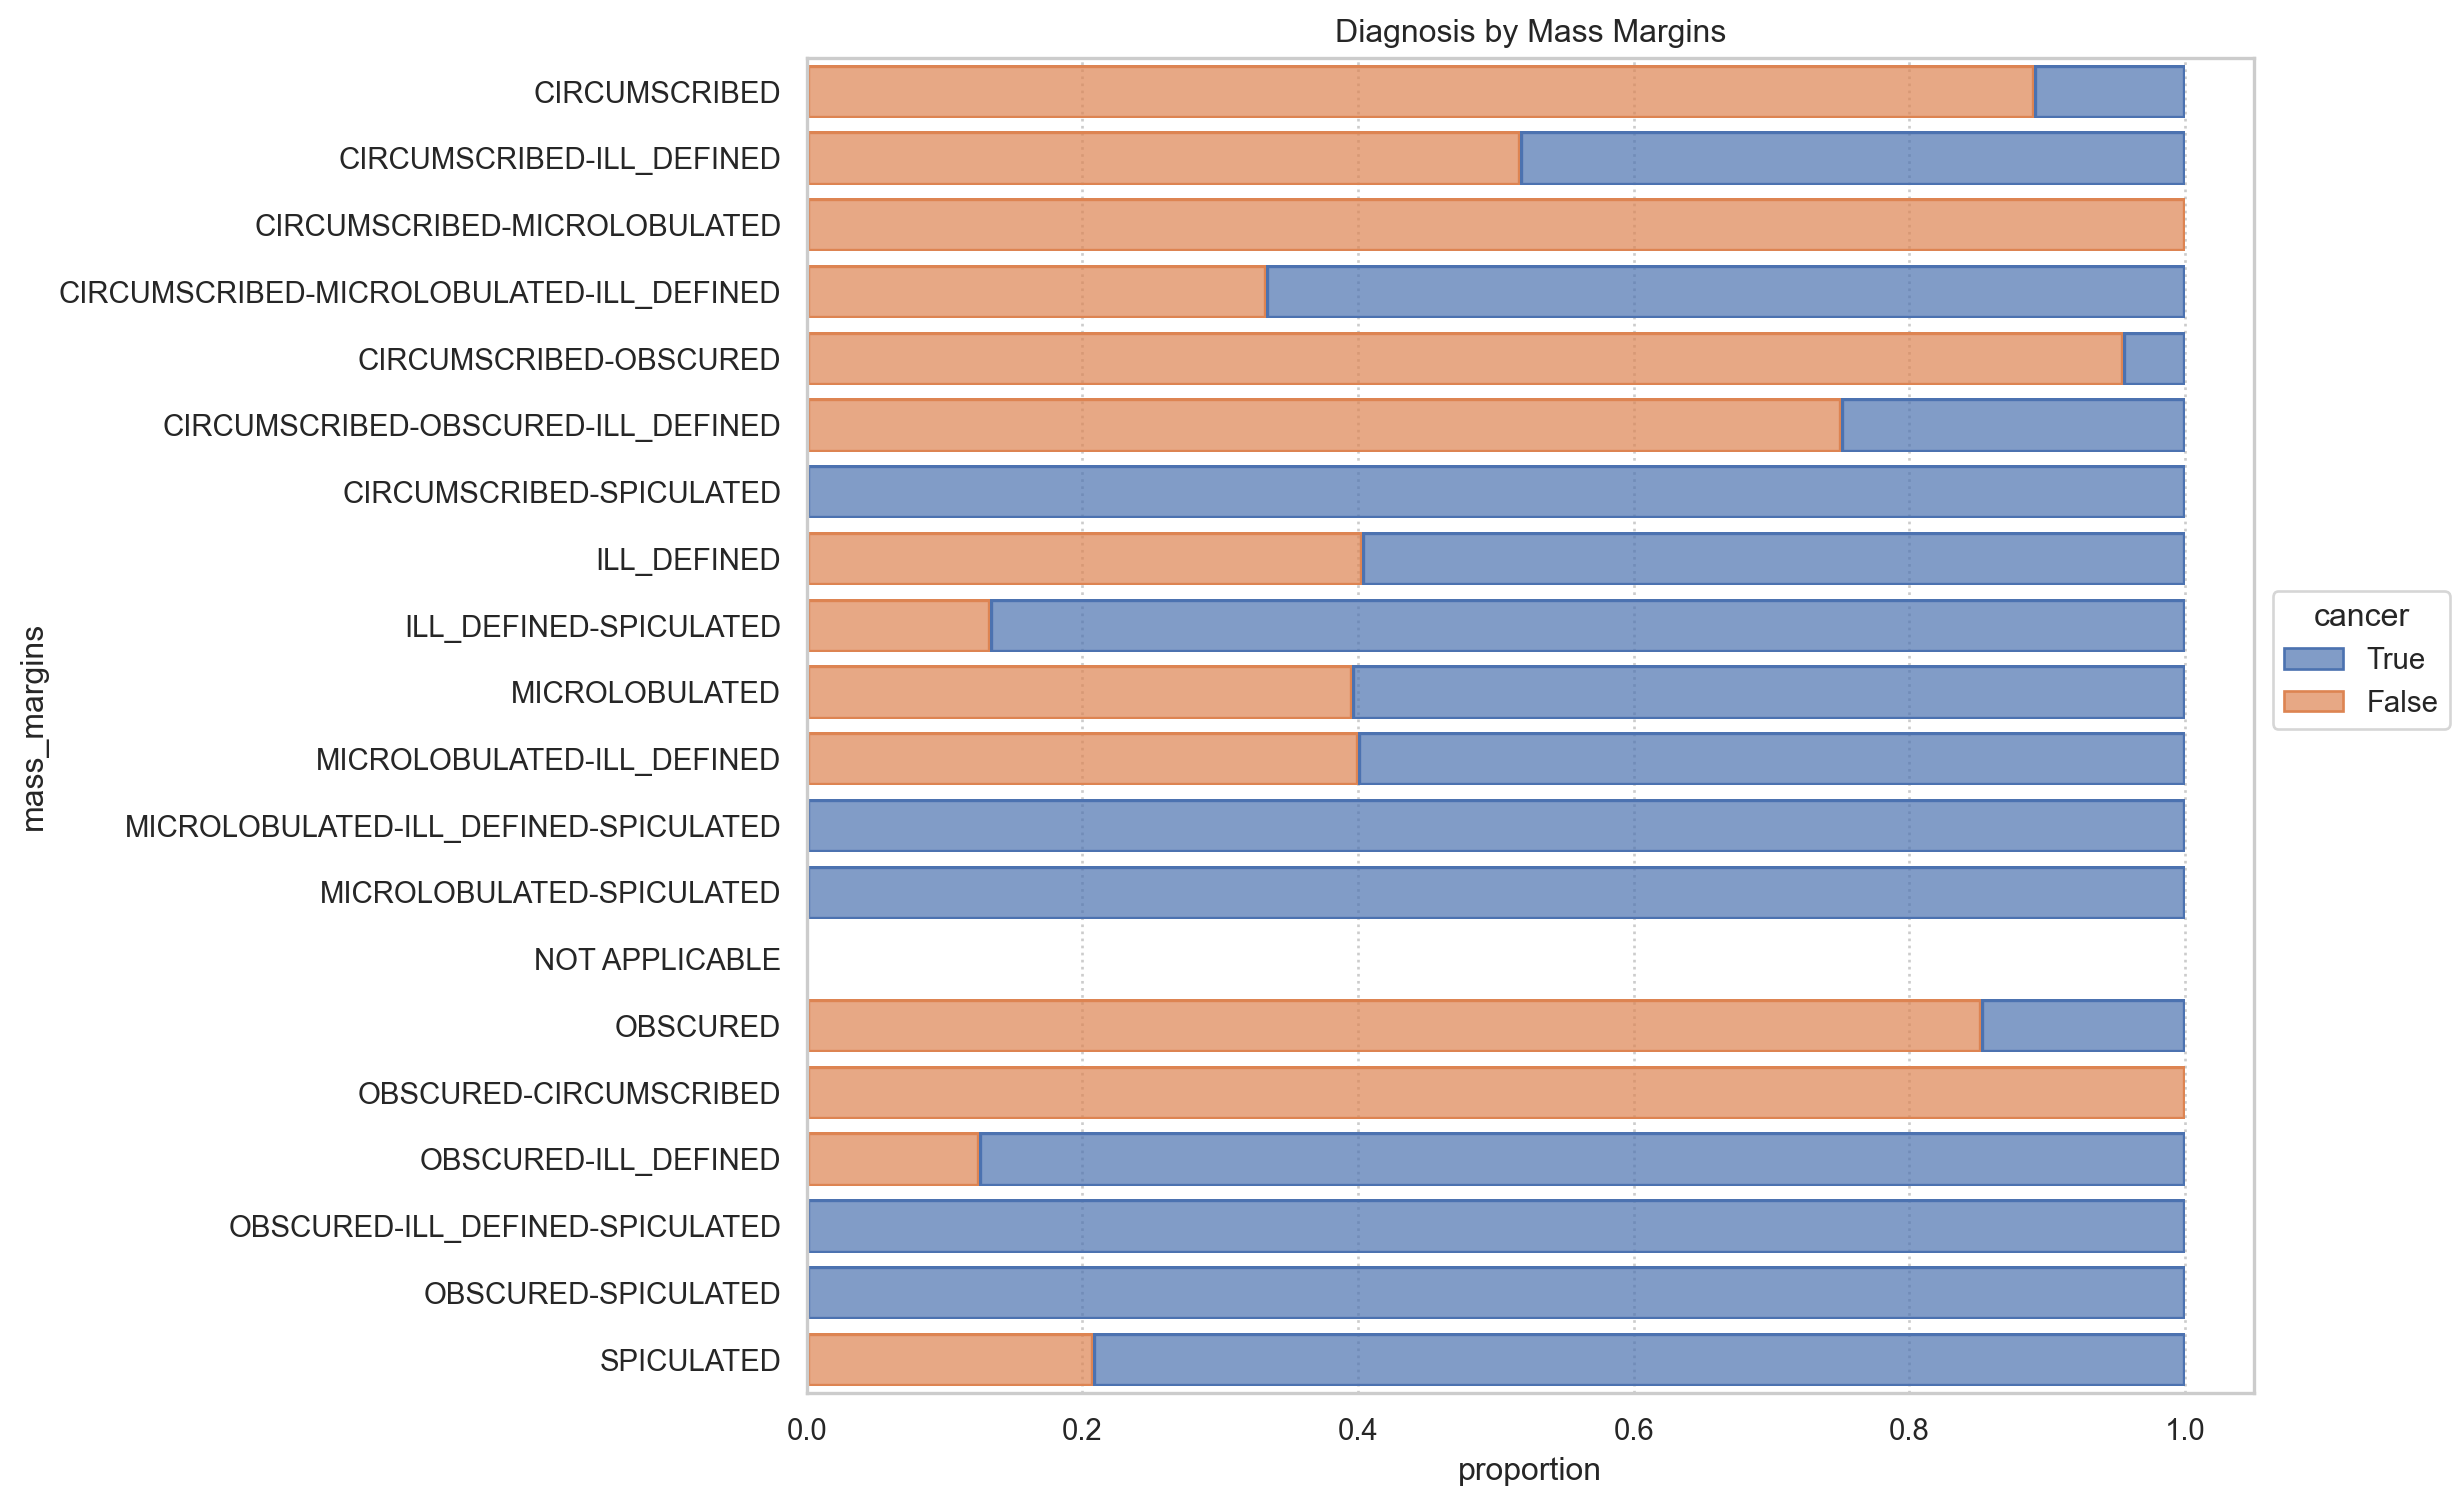

In [49]:
prop = df_mass[['mass_margins', 'cancer']].groupby(by=['mass_margins']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['mass_margins','cancer'])
sns.objects.Plot(prop, y='mass_margins', x='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Mass Margins").layout(size=(12,8), engine='tight')

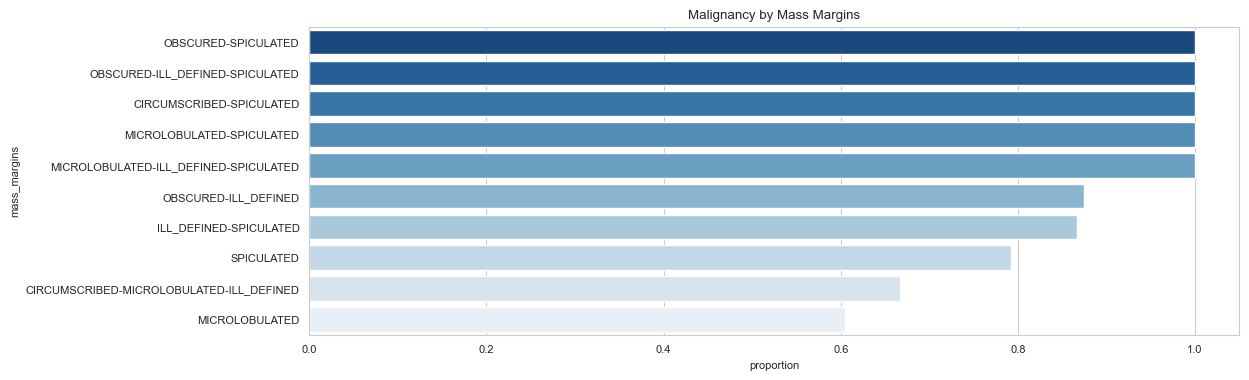

In [50]:
fig, ax = plt.subplots(figsize=(12,4))
mass_margins = cases.get_most_malignant_mass(x='mass_margins', n=10)
mass.plot.barplot(data=mass_margins, y='mass_margins', x='proportion', title='Malignancy by Mass Margins', ax=ax)

In [51]:
cv = mass.stats.cramersv(a='mass_margins', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.5894681913733985
                          Pvalue | 2.1871720584088994e-113
                           Alpha | 0.05
                        Strength | Large
                               A | mass_margins
                               B | cancer
                               N | 1694
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 588.6188361978973
                           X2dof | 18




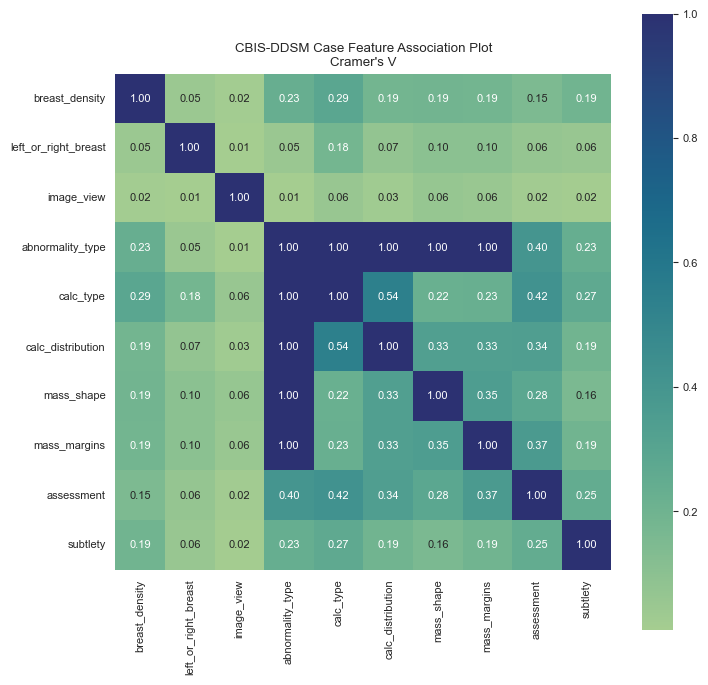

In [52]:
fig, ax = plt.subplots(figsize=(8,8))
cases.plot_feature_associations(ax=ax)

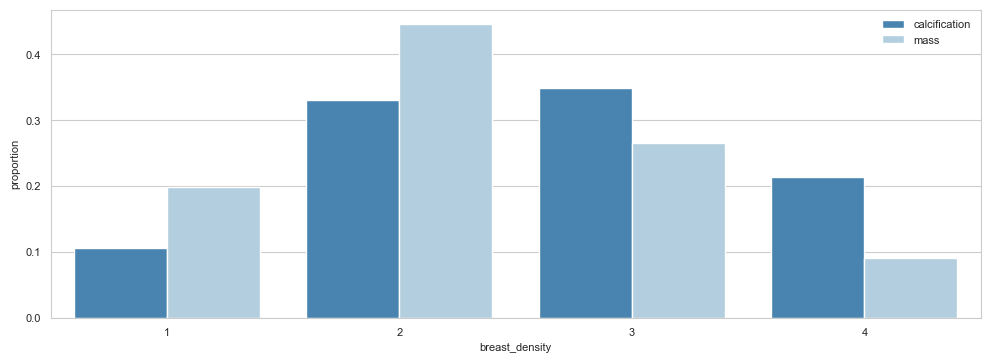

In [53]:
fig, ax = plt.subplots(figsize=(12,4))
df = cases.as_df()
df_props = df[['abnormality_type', 'breast_density']].groupby(by=['abnormality_type']).value_counts(normalize=True, sort=False).to_frame().reset_index()
cases.plot.barplot(data=df_props, x='breast_density', y='proportion', hue='abnormality_type', ax=ax)

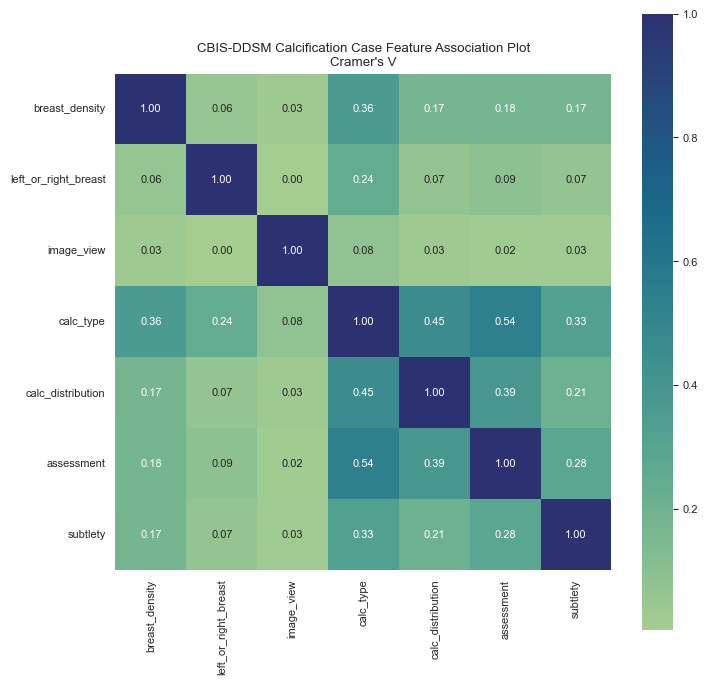

In [54]:
fig, ax = plt.subplots(figsize=(8,8))
calc.plot_calc_feature_associations(ax=ax)

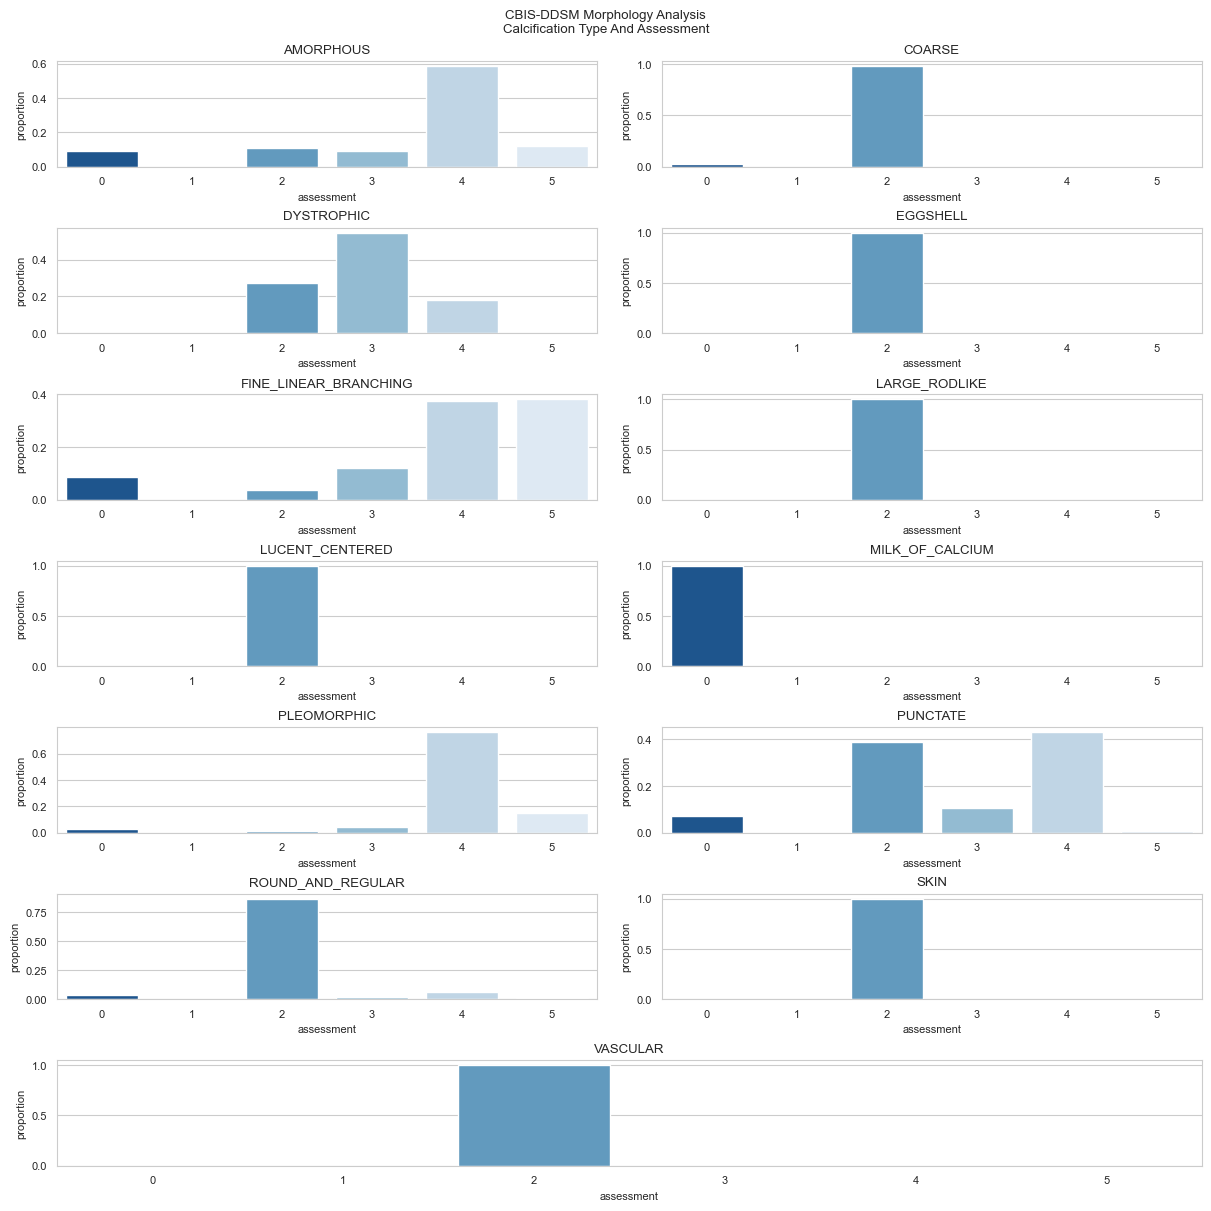

In [55]:
_ = cases.summarize_morphology_by_feature(morphology='calc_type', by='assessment', figsize=(12,12))

In [56]:
cv = calc.stats.cramersv(a='calc_type', b='assessment')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.5399745903685791
                          Pvalue | 0.0
                           Alpha | 0.05
                        Strength | Large
                               A | calc_type
                               B | assessment
                               N | 1872
                             Dof | 4
                         X2alpha | 0.05
                              X2 | 2183.2953161289365
                           X2dof | 168




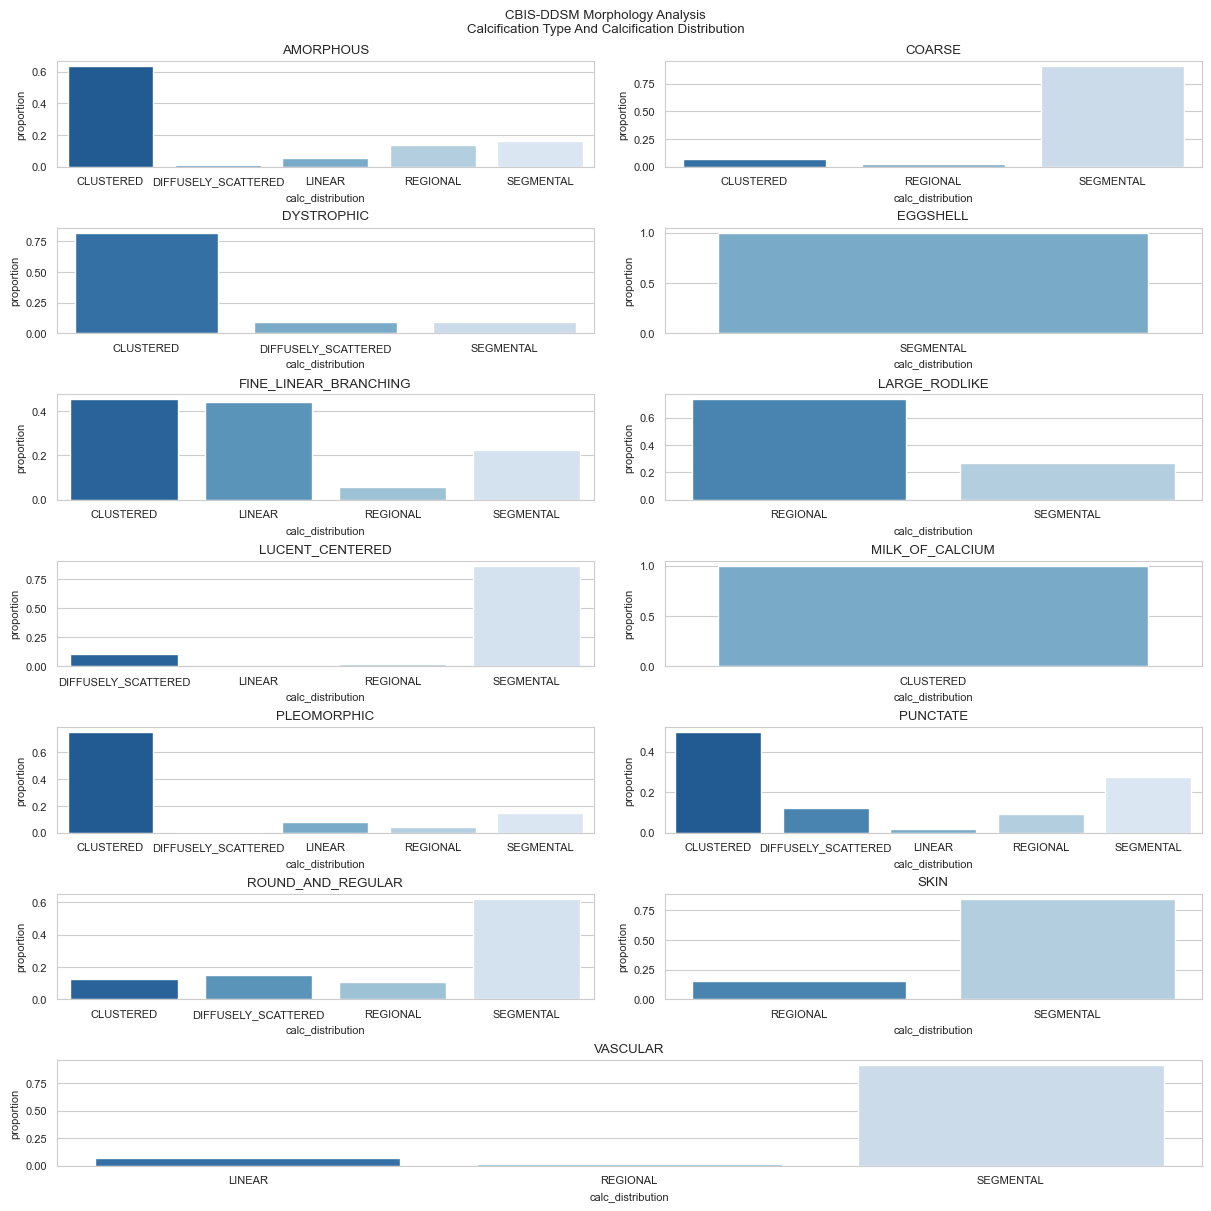

In [57]:
_ = cases.compare_morphology(m1='calc_type', m2='calc_distribution', figsize=(12,12))

In [58]:
cv = calc.stats.cramersv(a='calc_type', b='calc_distribution')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.45403619931007766
                          Pvalue | 0.0
                           Alpha | 0.05
                        Strength | Large
                               A | calc_type
                               B | calc_distribution
                               N | 1872
                             Dof | 8
                         X2alpha | 0.05
                              X2 | 3087.2854813722943
                           X2dof | 336




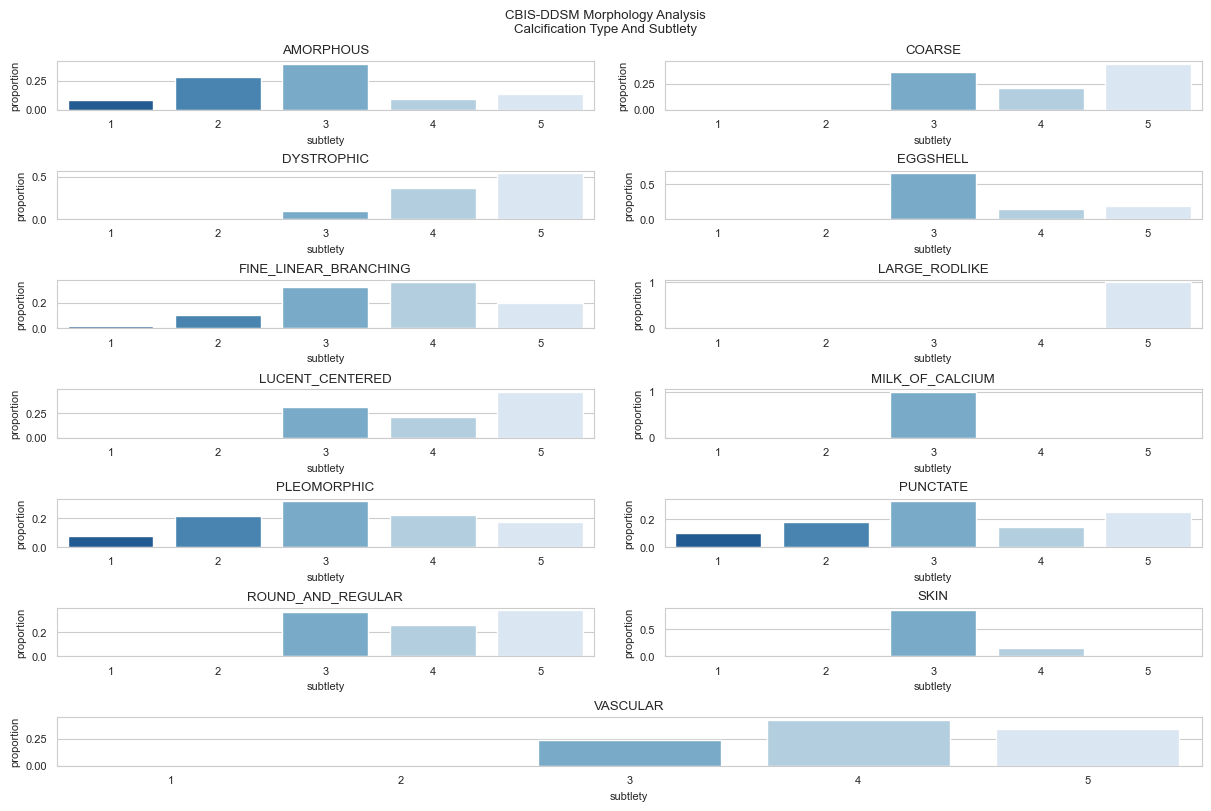

In [59]:
_ = cases.summarize_morphology_by_feature(morphology='calc_type', by='subtlety')

In [60]:
cv = calc.stats.cramersv(a='calc_type', b='subtlety')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.32542688359496785
                          Pvalue | 9.164653782848766e-82
                           Alpha | 0.05
                        Strength | Large
                               A | calc_type
                               B | subtlety
                               N | 1872
                             Dof | 4
                         X2alpha | 0.05
                              X2 | 792.9990923686997
                           X2dof | 168




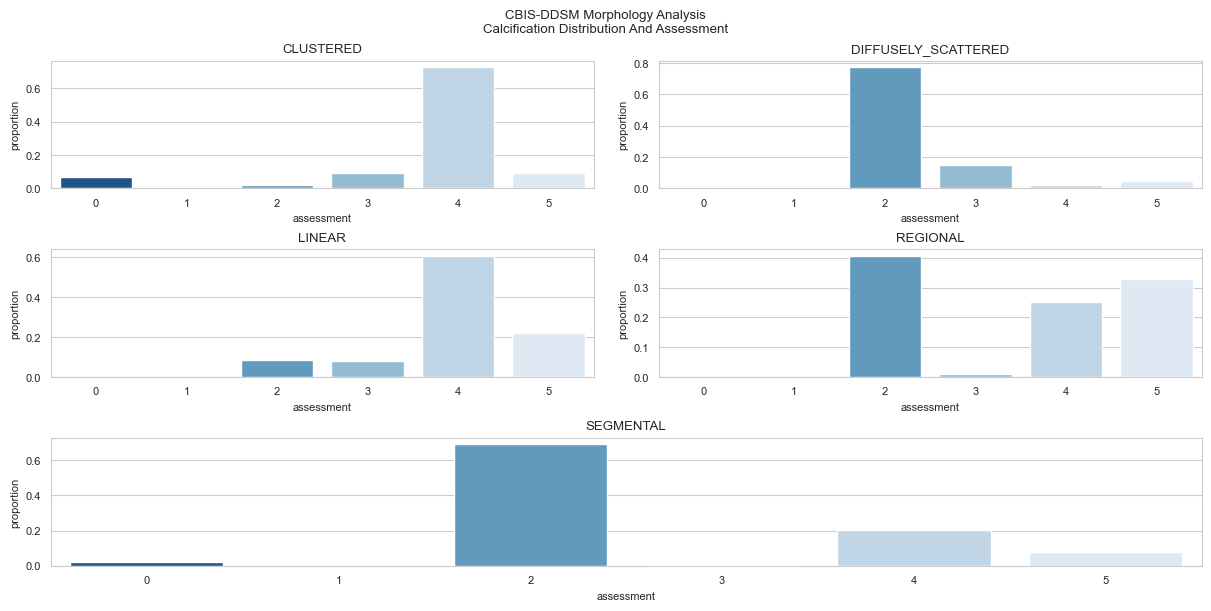

In [61]:
_ = cases.summarize_morphology_by_feature(morphology='calc_distribution', by='assessment', figsize=(12,6))

In [62]:
cv = calc.stats.cramersv(a='calc_distribution', b='assessment')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.38789958530499524
                          Pvalue | 3.1562872500601785e-216
                           Alpha | 0.05
                        Strength | Large
                               A | calc_distribution
                               B | assessment
                               N | 1872
                             Dof | 4
                         X2alpha | 0.05
                              X2 | 1126.690069039047
                           X2dof | 32




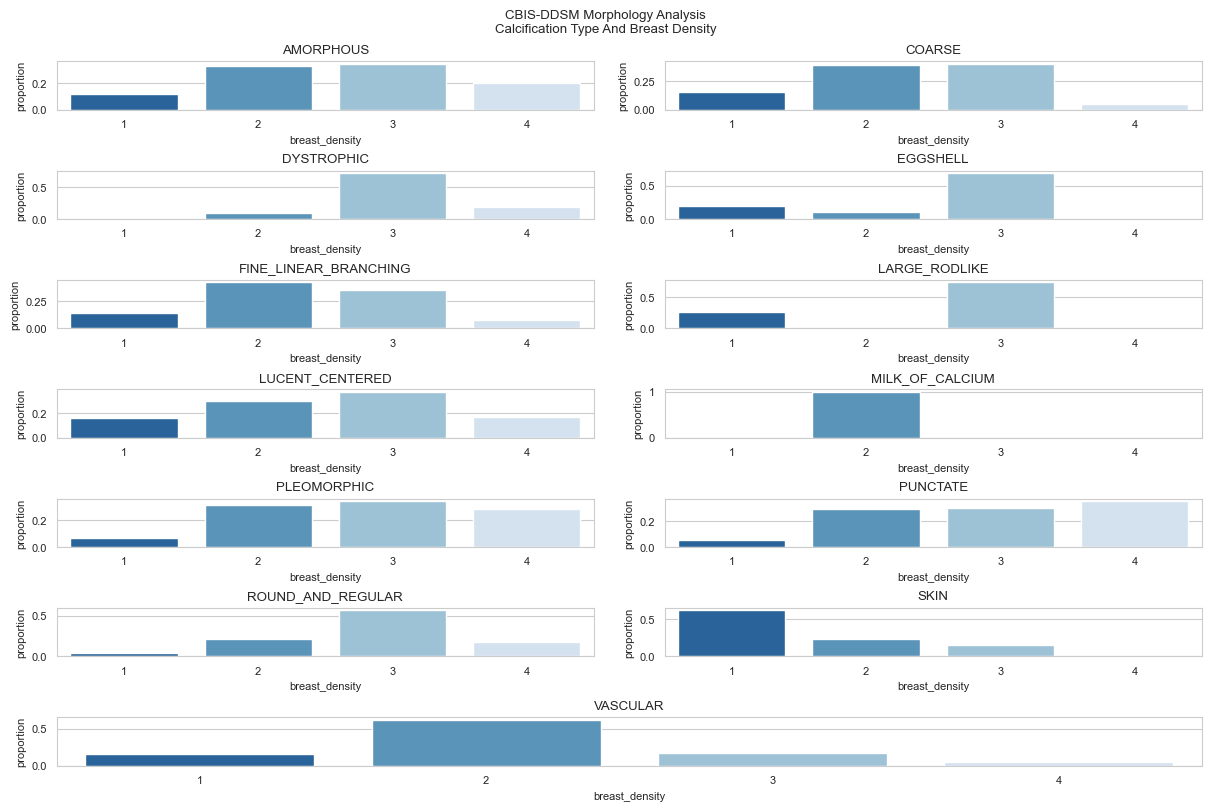

In [63]:
_ = cases.summarize_morphology_by_feature(morphology='calc_type', by='breast_density', figsize=(12,8))

In [64]:
cv = calc.stats.cramersv(a='breast_density', b='calc_type')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.3552474787413507
                          Pvalue | 5.624419427603362e-82
                           Alpha | 0.05
                        Strength | Large
                               A | breast_density
                               B | calc_type
                               N | 1872
                             Dof | 3
                         X2alpha | 0.05
                              X2 | 708.7435307901172
                           X2dof | 126




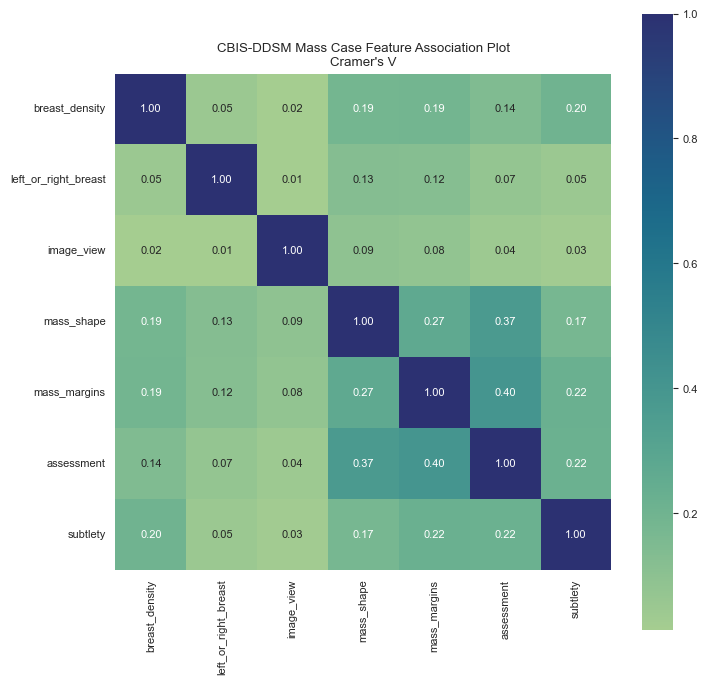

In [65]:
fig, ax = plt.subplots(figsize=(8,8))
mass.plot_mass_feature_associations(ax=ax)

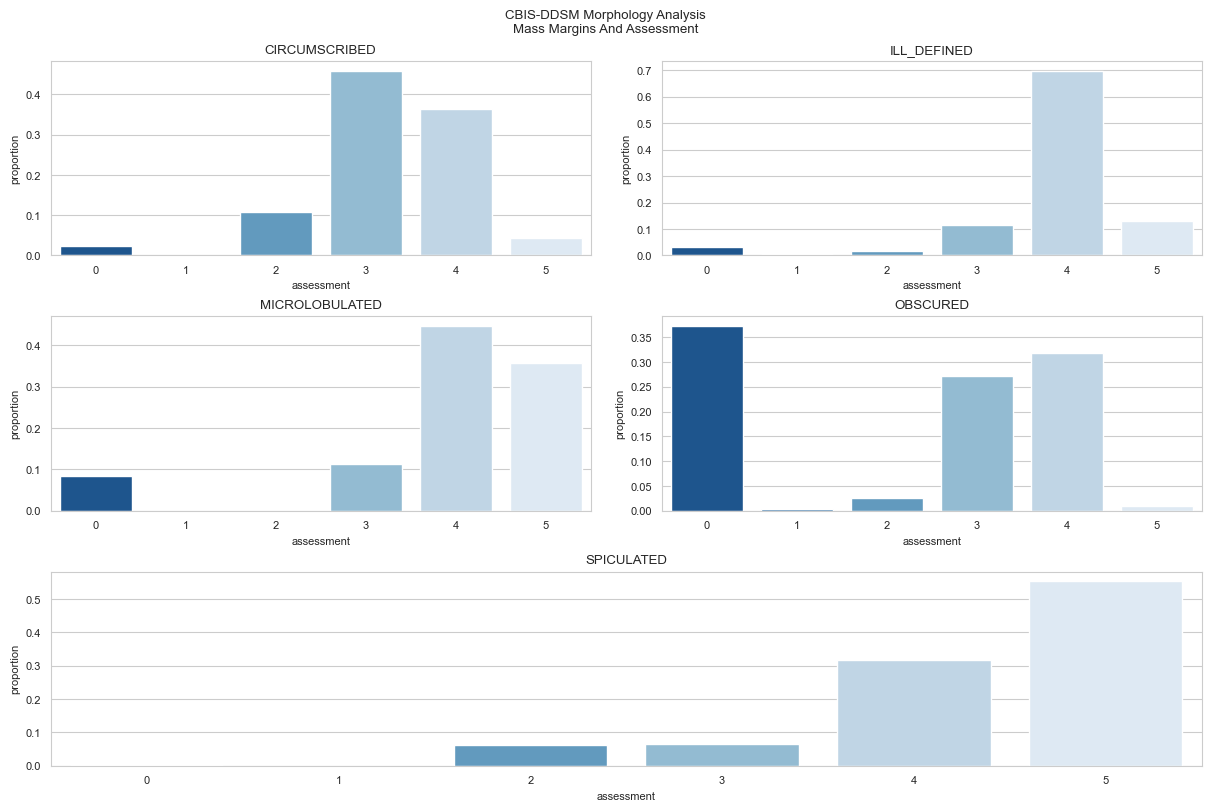

In [66]:
_ = cases.summarize_morphology_by_feature(morphology='mass_margins', by='assessment', figsize=(12,8))

In [67]:
cv = mass.stats.cramersv(a='mass_margins', b='assessment')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.40037910751937816
                          Pvalue | 2.3306037914870686e-225
                           Alpha | 0.05
                        Strength | Large
                               A | mass_margins
                               B | assessment
                               N | 1694
                             Dof | 5
                         X2alpha | 0.05
                              X2 | 1357.7700498809766
                           X2dof | 90




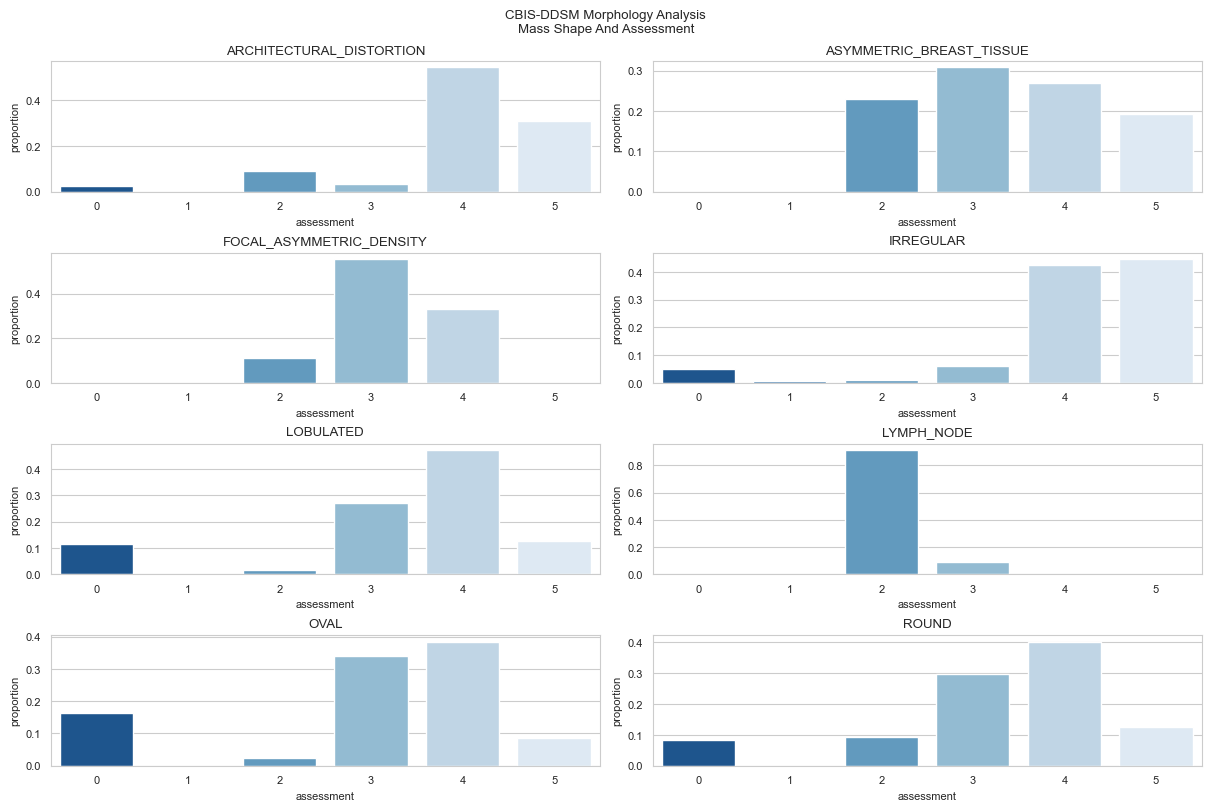

In [68]:
_ = cases.summarize_morphology_by_feature(morphology='mass_shape', by='assessment', figsize=(12,8))

In [69]:
cv = mass.stats.cramersv(a='mass_shape', b='assessment')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.3693905740902926
                          Pvalue | 8.3746514669523e-182
                           Alpha | 0.05
                        Strength | Large
                               A | mass_shape
                               B | assessment
                               N | 1694
                             Dof | 5
                         X2alpha | 0.05
                              X2 | 1155.7263860406229
                           X2dof | 95




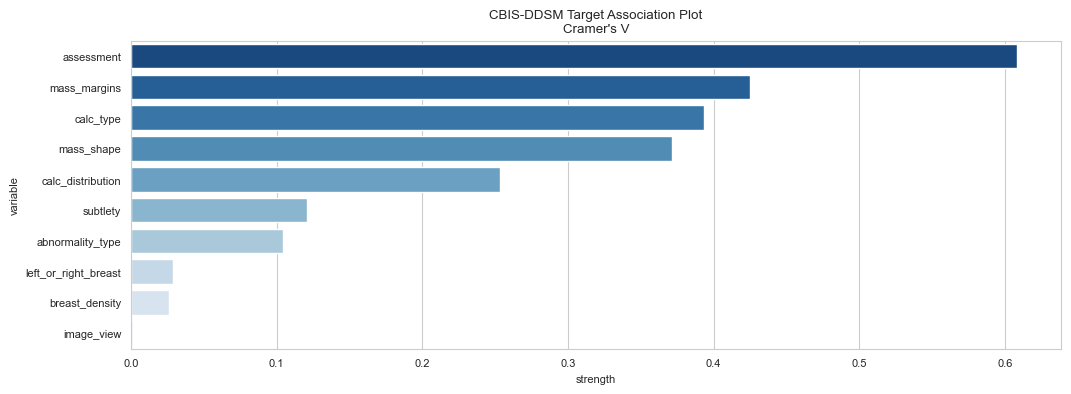

In [70]:
cases.plot_target_associations()

In [71]:
FORCE_MODEL_FIT = False

In [72]:
pb = PipelineBuilder()
pb.set_jobs(6)
pb.set_standard_scaler()
pb.set_scorer('accuracy')

# Build Logistic Regression Pipeline
params_lr = [{'clf__penalty': ['l1', 'l2'],
		      'clf__C': [1.0, 0.5, 0.1],
		      'clf__solver': ['liblinear']}]
clf = LogisticRegression(random_state=5)
pb.set_classifier(classifier=clf, params=params_lr)
pb.build_gridsearch_cv()
lr = pb.pipeline

# Build SVM Pipeline
clf = SVC(random_state=5)
params_svc = [{'clf__kernel': ['linear'],
		       'clf__C': [1,2,3,4,5, 6, 7, 8, 9, 10]}]
pb.set_classifier(classifier=clf, params=params_svc)
pb.build_gridsearch_cv()
svc = pb.pipeline

# Build Random Forest Pipeline
clf = RandomForestClassifier(random_state=5)
param_range = [1,2,3,4,5]
params_rf = [{'clf__criterion': ['gini', 'entropy'],
		      'clf__min_samples_leaf': param_range,
		      'clf__max_depth': param_range,
		      'clf__min_samples_split': param_range[1:]}]
pb.set_classifier(classifier=clf, params=params_rf)
pb.build_gridsearch_cv()
rf = pb.pipeline

In [73]:
X_train, y_train, X_test, y_test = cases.get_calc_model_data()
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

In [74]:
BEST_CALC_MODEL_FP = os.path.abspath('model/eda/best_calc_pipeline.pkl')

In [75]:
# Build Model Selector
calc_ms = ModelSelector(filepath=BEST_CALC_MODEL_FP)
calc_ms.add_pipeline(pipeline=lr, name="Logistic Regression")
calc_ms.add_pipeline(pipeline=svc, name="Support Vector Classifier")
calc_ms.add_pipeline(pipeline=rf, name="Random Forest")

In [76]:
calc_ms.run(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, force=FORCE_MODEL_FIT)
y_pred = calc_ms.predict(X=X)
calc_ms.score(y_true=y, y_pred=y_pred)

Best Model: Random Forest loaded from file.

		Accuracy of Random Forest: 0.75
			Classification Report
              precision    recall  f1-score   support

       False       0.73      0.96      0.83      1199
        True       0.83      0.37      0.51       673

    accuracy                           0.75      1872
   macro avg       0.78      0.66      0.67      1872
weighted avg       0.76      0.75      0.71      1872



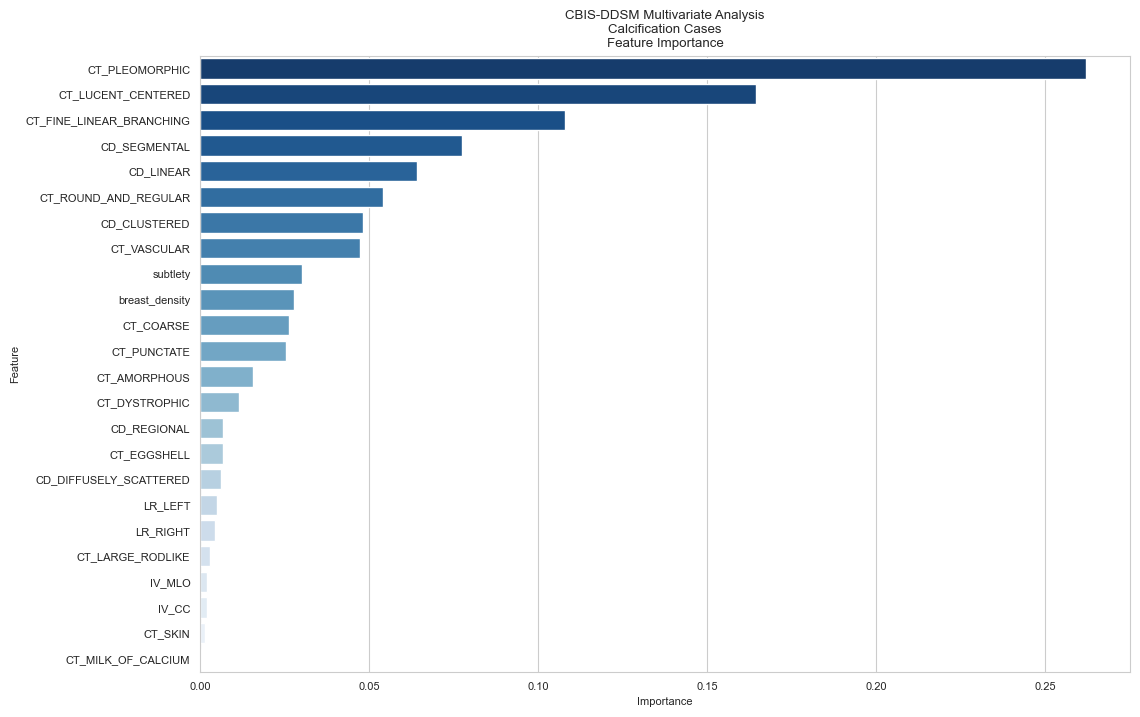

In [77]:
fig, ax = plt.subplots(figsize=(12,8))
title = f"CBIS-DDSM Multivariate Analysis\nCalcification Cases\nFeature Importance"
calc_ms.plot_feature_importance(title=title, ax=ax)

In [78]:
X_train, y_train, X_test, y_test = cases.get_mass_model_data()
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

In [79]:
BEST_MASS_MODEL_FP = os.path.abspath('model/eda/best_mass_pipeline.pkl')

In [80]:
# Build Model Selector
mass_ms = ModelSelector(filepath=BEST_MASS_MODEL_FP)
mass_ms.add_pipeline(pipeline=lr, name="Logistic Regression")
mass_ms.add_pipeline(pipeline=svc, name="Support Vector Classifier")
mass_ms.add_pipeline(pipeline=rf, name="Random Forest")

In [81]:
mass_ms.run(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, force=FORCE_MODEL_FIT)
y_pred = mass_ms.predict(X=X)
mass_ms.score(y_true=y, y_pred=y_pred)

Best Model: Random Forest loaded from file.

		Accuracy of Random Forest: 0.81
			Classification Report
              precision    recall  f1-score   support

       False       0.85      0.79      0.82       910
        True       0.77      0.84      0.81       784

    accuracy                           0.81      1694
   macro avg       0.81      0.81      0.81      1694
weighted avg       0.82      0.81      0.81      1694



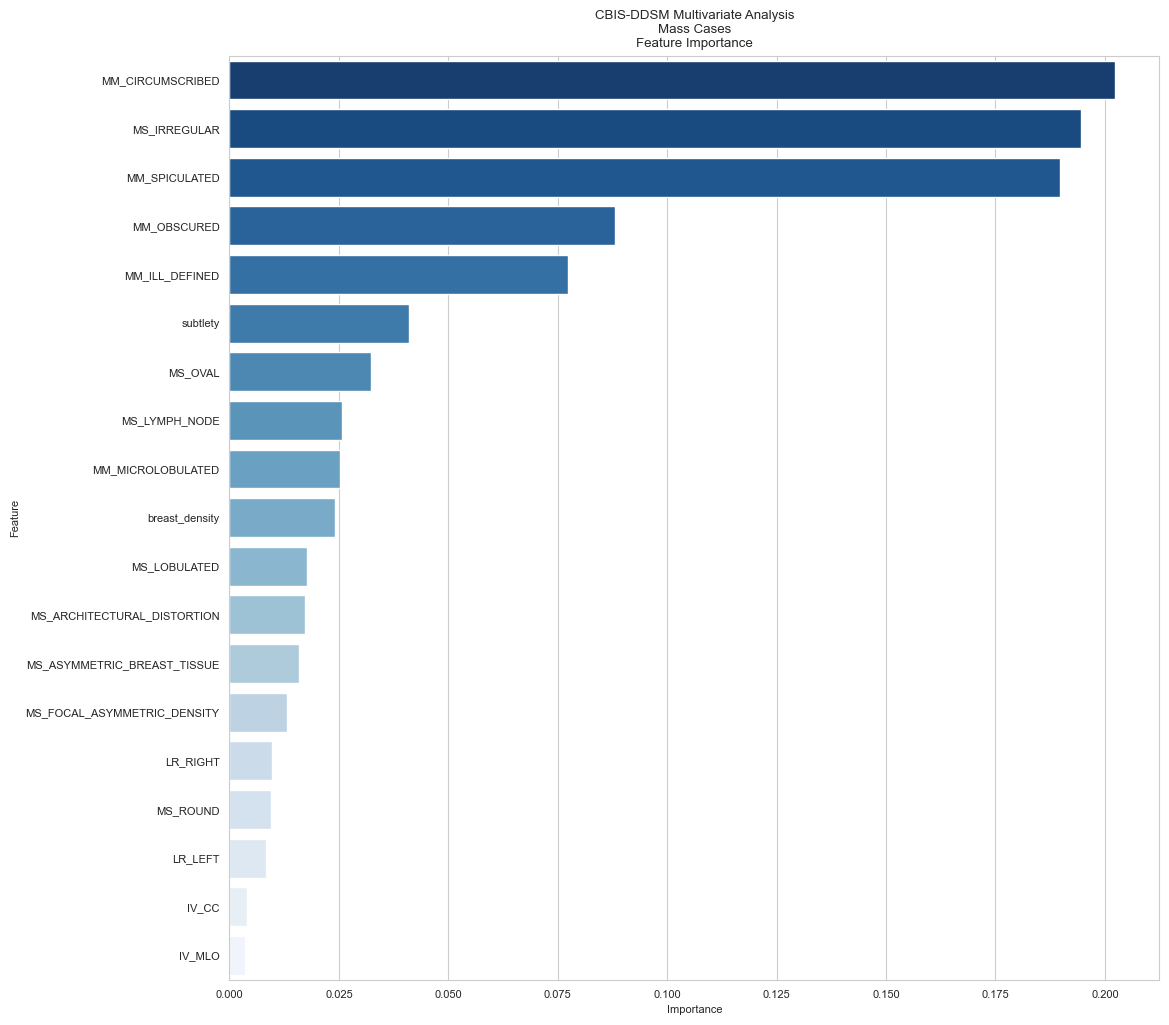

In [82]:
fig, ax = plt.subplots(figsize=(12,12))
title = f"CBIS-DDSM Multivariate Analysis\nMass Cases\nFeature Importance"
mass_ms.plot_feature_importance(title=title, ax=ax)